In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [1]:
import cv2
import numpy as np
from skimage import io, morphology, measure
from skimage.io import imread
import os
from scipy.ndimage import binary_dilation, generate_binary_structure
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
import matplotlib.colors as mcolors
from skimage import morphology
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy.ndimage import binary_erosion, binary_dilation, generate_binary_structure
import matplotlib.patches as mpatches
from scipy.stats import binned_statistic
from scipy.spatial import distance
from skimage.transform import resize
from PIL import Image
import glob
import os
from scipy.ndimage import gaussian_filter1d
from scipy.signal import correlate
from scipy.ndimage import gaussian_filter1d

In [2]:
def load_tif_files(path):
    image = io.imread(path)
    
    return image

#function to load the dictionary of the mask

def load_mask_data(mask_path):
    mask_dict = np.load(mask_path, allow_pickle=True).item()
    outlines = mask_dict['outlines']
    colors = mask_dict['colors']
    masks = mask_dict['masks']
    
    return masks

#function to map each nucleus ID to its pixels

def create_id_to_pixels(masks):
    unique_ids = np.unique(masks)
    return {cell_id: np.argwhere(masks == cell_id) for cell_id in unique_ids if cell_id != 0}

#function to create the cytoplasm mask

def create_cyto_cut_mask(masks):
    
    dilated_nuclear_mask = np.zeros_like(masks, dtype=np.uint8)
    cyto_mask = np.zeros_like(masks)
    unique_ids = np.unique(masks)
    for cell_id in unique_ids:
        if cell_id == 0:
            continue
        nucleus_mask = masks == cell_id
        dilated_nucleus = binary_dilation(nucleus_mask, structure=generate_binary_structure(2, 2), iterations=2)
        cytoplasm_mask = dilated_nucleus & ~nucleus_mask
        cyto_mask = np.maximum(cyto_mask, cytoplasm_mask)
        dilated_nuclear_mask = np.maximum(dilated_nuclear_mask, dilated_nucleus)
    global_cyto_mask = np.zeros_like(masks, dtype=bool)
    overlap_mask = np.zeros_like(masks, dtype=bool)
    cytoplasm_contours = np.zeros_like(masks, dtype=bool)
    id_to_pixels = {cell_id: np.argwhere(masks == cell_id) for cell_id in np.unique(masks) if cell_id != 0}
    for nucleus_id in id_to_pixels.keys():
        nucleus_mask = masks == nucleus_id
        dilated_nucleus = binary_dilation(nucleus_mask, structure=generate_binary_structure(2, 2), iterations=2)
        cytoplasm_contours |= dilated_nucleus.astype(bool)
        overlap_mask |= (global_cyto_mask & dilated_nucleus.astype(bool))
        global_cyto_mask |= dilated_nucleus.astype(bool)
    cytoplasm_contours &= ~masks.astype(bool)
    cyto_cut_mask = cytoplasm_contours & ~overlap_mask
    
    return cyto_cut_mask

def create_cyto_cut_mask_modnuclcyto(masks):
    dilated_nuclear_mask = np.zeros_like(masks, dtype=np.uint8)
    cyto_mask = np.zeros_like(masks)
    unique_ids = np.unique(masks)
    for cell_id in unique_ids:
        if cell_id == 0:
            continue
        nucleus_mask = masks == cell_id
        dilated_nucleus = binary_dilation(nucleus_mask, structure=generate_binary_structure(2, 2), iterations=3)
        nucleus_gap = binary_dilation(nucleus_mask, structure=generate_binary_structure(2, 2), iterations=1)
        cytoplasm_mask = dilated_nucleus & ~nucleus_gap
        cyto_mask = np.maximum(cyto_mask, cytoplasm_mask)
        dilated_nuclear_mask = np.maximum(dilated_nuclear_mask, dilated_nucleus)
    global_cyto_mask = np.zeros_like(masks, dtype=bool)
    overlap_mask = np.zeros_like(masks, dtype=bool)
    cytoplasm_contours = np.zeros_like(masks, dtype=bool)
    id_to_pixels = {cell_id: np.argwhere(masks == cell_id) for cell_id in unique_ids if cell_id != 0}
    for nucleus_id in id_to_pixels.keys():
        nucleus_mask = masks == nucleus_id
        dilated_nucleus = binary_dilation(nucleus_mask, structure=generate_binary_structure(2, 2), iterations=3)
        cytoplasm_contours |= dilated_nucleus.astype(bool)
        overlap_mask |= (global_cyto_mask & dilated_nucleus.astype(bool))
        global_cyto_mask |= dilated_nucleus.astype(bool)
    cytoplasm_contours &= ~masks.astype(bool)
    cyto_cut_mask = cytoplasm_contours & ~overlap_mask
    return cyto_cut_mask

def calculate_intensity_ratio_modnuclcyto(nucleus_pixels, mod_erk, masks, cyto_cut_mask, nucleus_id):
    nucleus_mask = masks == nucleus_id

    eroded_nucleus_mask = binary_erosion(nucleus_mask, structure=generate_binary_structure(2, 2), iterations=2)

    eroded_nucleus_pixels = np.array(np.nonzero(eroded_nucleus_mask)).T
    if eroded_nucleus_pixels.size == 0:
        return np.nan
    nucleus_intensity = np.mean(mod_erk[eroded_nucleus_pixels[:, 0], eroded_nucleus_pixels[:, 1]])

    dilated_nucleus = binary_dilation(nucleus_mask, structure=generate_binary_structure(2, 2), iterations=3)
    nucleus_gap = binary_dilation(nucleus_mask, structure=generate_binary_structure(2, 2), iterations=1)
    cytoplasm_mask = dilated_nucleus & ~nucleus_gap
    refined_cytoplasm_mask = cyto_cut_mask & cytoplasm_mask
    cytoplasm_pixels = np.array(np.nonzero(refined_cytoplasm_mask)).T

    if cytoplasm_pixels.size == 0:
        return np.nan
    cytoplasm_intensity = np.mean(mod_erk[cytoplasm_pixels[:, 0], cytoplasm_pixels[:, 1]])

    if cytoplasm_intensity <= 0 or nucleus_intensity <= 0:
        return np.nan

    ratio = cytoplasm_intensity / nucleus_intensity
    return np.log2(ratio)

def apply_masks(masks, tissue_mask):
    psm_mask = tissue_mask == 1
    somites_mask = tissue_mask >= 2

    filtered_nuclei_psm = masks * psm_mask
    filtered_nuclei_somites = masks * somites_mask
    filtered_masks = filtered_nuclei_psm + filtered_nuclei_somites
    
    return filtered_masks, psm_mask, somites_mask, filtered_nuclei_psm, filtered_nuclei_somites

#function to have the log2_nc_values in a function to use them later

def compute_log2_nc_values(masks, mod_erk, cyto_cut_mask, id_to_pixels):
    log2_nc_values = np.full(masks.shape, np.nan)
    for nucleus_id, nucleus_pixels in id_to_pixels.items():
        log2_nc_value = calculate_intensity_ratio_modnuclcyto(nucleus_pixels, mod_erk, masks, cyto_cut_mask, nucleus_id)
        for x, y in nucleus_pixels:
            if masks[x, y]:
                log2_nc_values[x, y] = log2_nc_value

    return log2_nc_values

#function to calculate the log2(C/N) in somites and psm

def compute_ratios(id_to_pixels, mod_erk, filtered_nuclei_psm, filtered_nuclei_somites, cyto_cut_mask):
    ratios_psm = {}
    ratios_somites = {}

    for nucleus_id, nucleus_pixels in id_to_pixels.items():
        nucleus_mask = np.zeros_like(filtered_nuclei_psm, dtype=bool)
        #valid_pixels = nucleus_pixels[(nucleus_pixels[:, 0] < nucleus_mask.shape[0]) & 
                                  #(nucleus_pixels[:, 1] < nucleus_mask.shape[1])]
        #nucleus_mask[valid_pixels[:, 0], valid_pixels[:, 1]] = True        
        nucleus_mask[nucleus_pixels[:, 0], nucleus_pixels[:, 1]] = True
        psm_mask = filtered_nuclei_psm > 0
        somites_mask = filtered_nuclei_somites > 0
        if np.any(nucleus_mask & psm_mask):
            ratio_psm = calculate_intensity_ratio_modnuclcyto(nucleus_pixels, mod_erk, filtered_nuclei_psm, cyto_cut_mask, nucleus_id)
            if not np.isnan(ratio_psm):
                ratios_psm[nucleus_id] = ratio_psm
        if np.any(nucleus_mask & somites_mask):
            ratio_somites = calculate_intensity_ratio_modnuclcyto(nucleus_pixels, mod_erk, filtered_nuclei_somites, cyto_cut_mask, nucleus_id)
            if not np.isnan(ratio_somites):
                ratios_somites[nucleus_id] = ratio_somites

    return ratios_psm, ratios_somites

#function to visualize the log2(N/C) in the embryo with a colormap

def visualize_log2_nc(filtered_masks, log2_nc_values, id_to_pixels, ratios_psm, ratios_somites, vmin, vmax, save_path=None):
#def visualize_log2_nc(filtered_masks, log2_nc_values, id_to_pixels, ratios_psm, ratios_somites, save_path=None):
    log2_nc_values = np.full(filtered_masks.shape, np.nan)
    for nucleus_id, nucleus_pixels in id_to_pixels.items():
        if nucleus_id in ratios_psm:
            log2_nc_value = ratios_psm[nucleus_id]
            for x, y in nucleus_pixels:
                if filtered_masks[x, y]:
                    log2_nc_values[x, y] = log2_nc_value
        if nucleus_id in ratios_somites:
            log2_nc_value = ratios_somites[nucleus_id]
            for x, y in nucleus_pixels:
                if filtered_masks[x, y]:
                    log2_nc_values[x, y] = log2_nc_value
    #vmin = np.nanmin(log2_nc_values)  
    #vmax = np.nanmax(log2_nc_values)
    colors = ['red', 'orange', 'cyan',  'blue']
    n_bins = 30
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    fig = plt.figure(figsize=(10, 8))
    plt.imshow(filtered_masks, cmap='gray', vmin=0, vmax=1)
    img2 = plt.imshow(log2_nc_values, cmap=cmap, norm=norm, alpha=0.5)
    #img2 = plt.imshow(log2_nc_values, cmap='jet', alpha=0.5)
    cbar = plt.colorbar(img2, orientation='vertical', fraction=0.008, pad=0.1, aspect=50)
    cbar.set_label('log2(N/C)')
    ticks = np.linspace(vmin, vmax, num=5)
    if vmin <= 0 <= vmax:
        ticks = np.sort(np.unique(np.concatenate([ticks, [0]])))
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{tick:.2f}' for tick in ticks])
    plt.axis('off')
    if save_path:
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)
    return fig

def binary_visualization(filtered_masks, log2_nc_values, id_to_pixels, ratios_psm, ratios_somites, binary_path=None):
    binary_values = np.full(filtered_masks.shape, np.nan)
    for nucleus_id, nucleus_pixels in id_to_pixels.items():
        if nucleus_id in ratios_psm:
            log2_nc_value = ratios_psm[nucleus_id]
            binary_value = 1 if log2_nc_value > 0 else 0
            for x, y in nucleus_pixels:
                if filtered_masks[x, y]:
                    binary_values[x, y] = binary_value
        if nucleus_id in ratios_somites:
            log2_nc_value = ratios_somites[nucleus_id]
            binary_value = 1 if log2_nc_value > 0 else 0
            for x, y in nucleus_pixels:
                if filtered_masks[x, y]:
                    binary_values[x, y] = binary_value
    cmap = mcolors.ListedColormap(['cyan', 'purple'])
    bounds = [-0.5, 0.5, 1.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    fig1 = plt.figure(figsize=(10, 8))
    plt.imshow(filtered_masks, cmap='gray', vmin=0, vmax=1)
    img2 = plt.imshow(binary_values, cmap=cmap, norm=norm, alpha=0.5)
    purple_patch = mpatches.Patch(color='cyan', label='active')
    turquoise_patch = mpatches.Patch(color='purple', label='inactive')
    plt.legend(handles=[purple_patch, turquoise_patch], loc='upper left', fontsize='large')
    plt.axis('off')
    if binary_path:
        fig1.savefig(binary_path, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig1)
    return fig1

def filter_nuclei_in_mask(nuclei_pixels, mask):
    filtered_nuclei = {}
    for nucleus_id, pixels in nuclei_pixels.items():
        if np.any(mask[tuple(pixels.T)]): 
            filtered_nuclei[nucleus_id] = pixels
    return filtered_nuclei

#functions to find the closest point on the LOI to identify each nucleus
def find_closest_point_on_loi(nucleus_position, loi_points):
    dists = distance.cdist([nucleus_position], loi_points)
    min_index = np.argmin(dists)
    return min_index, dists[0, min_index]

#function to calculate the distance of the nuclei from the LOI
def calculate_nuclei_to_loi_distances(filtered_nuclei,loi_points):
    nuclei_to_loi_x = {}
    for nucleus_id, nucleus_pixels in filtered_nuclei.items():
        if nucleus_pixels.size > 0:
            nucleus_centroid = np.mean(nucleus_pixels, axis=0)
            loi_index, _ = find_closest_point_on_loi(nucleus_centroid, loi_points)
            nuclei_to_loi_x[nucleus_id] = loi_index
    return nuclei_to_loi_x

def find_closest_point_on_lois(nucleus_position, loi_points):
    dists = distance.cdist([nucleus_position], loi_points)
    min_index = np.argmin(dists)
    return min_index, dists[0, min_index]

def calculate_intensity_ratios_modnuclcyto(nucleus_pixels, mod_erk, masks, cyto_mask, nucleus_id):
    nucleus_pixels = np.array(nucleus_pixels)
    if nucleus_pixels.size == 0:
        return np.nan
    nucleus_intensity = np.mean(mod_erk[nucleus_pixels[:, 0], nucleus_pixels[:, 1]])
    nucleus_mask = masks == nucleus_id
    eroded_nucleus_mask = binary_erosion(nucleus_mask, structure=generate_binary_structure(2, 2), iterations=2)
    eroded_nucleus_pixels = np.array(np.nonzero(nucleus_mask)).T
    if eroded_nucleus_pixels.size == 0:
        return np.nan
    nucleus_intensity = np.mean(mod_erk[eroded_nucleus_pixels[:, 0], eroded_nucleus_pixels[:, 1]])
    dilated_nucleus = binary_dilation(nucleus_mask, structure=generate_binary_structure(2, 2), iterations=3)
    nucleus_gap = binary_dilation(nucleus_mask, structure=generate_binary_structure(2, 2), iterations=1)
    cytoplasm_mask = dilated_nucleus & ~nucleus_gap
    cytoplasm_pixels = np.array(np.nonzero(cytoplasm_mask)).T
    if cytoplasm_pixels.size == 0:
        return np.nan
    cytoplasm_intensity = np.mean(mod_erk[cytoplasm_pixels[:, 0], cytoplasm_pixels[:, 1]])
    if cytoplasm_intensity == 0:
        return np.nan
    ratio = cytoplasm_intensity / nucleus_intensity 
    return ratio

def plot_loi(ratios_psm, ratios_somites, y_min, y_max, save_path):
    fig = plt.figure(figsize=(10, 6))

    combined_ratios = {**ratios_psm, **ratios_somites}

    loi_positions = {}
    for nucleus_position, ratio in combined_ratios.items():
        if nucleus_position not in loi_positions:
            loi_positions[nucleus_position] = []
        loi_positions[nucleus_position].append(ratio)

    averaged_ratios = {pos: np.mean(ratios) for pos, ratios in loi_positions.items()}

    min_position = min(averaged_ratios.keys())
    distances = {pos: np.linalg.norm(np.array(pos) - np.array(min_position)) for pos in averaged_ratios.keys()}

    sorted_positions = sorted(distances, key=distances.get)
    averaged_values = [averaged_ratios[pos] for pos in sorted_positions]

    plt.plot(sorted_positions, averaged_values, color='purple', alpha=0.75)

    plt.xlabel('position along the PSM (a.u)')
    plt.ylabel('log2(N/C) modERK intensity')
    plt.grid(True)

    if y_min is not None and y_max is not None:
        plt.ylim(y_min, y_max)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        
    plt.show()
    return fig

def plot_loi_binned(ratios_psm, ratios_somites, num_bins, y_min, y_max, save_path):
    combined_ratios = {**ratios_psm, **ratios_somites}
    sorted_positions = sorted(combined_ratios.keys())
    sorted_ratios = [combined_ratios[pos] for pos in sorted_positions]
    bin_edges = np.linspace(min(sorted_positions), max(sorted_positions), num_bins + 1)
    binned_means = []
    bin_centers = []
    
    for i in range(1, len(bin_edges)):
        # Find all ratios that fall into the current bin
        bin_mask = (np.array(sorted_positions) >= bin_edges[i - 1]) & (np.array(sorted_positions) < bin_edges[i])
        if np.any(bin_mask):
            binned_mean = np.mean(np.array(sorted_ratios)[bin_mask])
            binned_means.append(binned_mean)
            bin_centers.append((bin_edges[i - 1] + bin_edges[i]) / 2)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(bin_centers, binned_means, color='purple', alpha=0.75)
    plt.xlabel('position along the PSM (a.u)')
    plt.ylabel('log2(N/C) modERK intensity')
    plt.title('binned plot (n bins=50)')
    plt.grid(True)
    if y_min is not None and y_max is not None:
        plt.ylim(y_min, y_max)
    if save_path:
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    return fig

#in this way colormap and binarymap will be saved with the same dimension, so only the output image is normalized, not all the array

def rescale_along_x(image, tissue_mask, target_width):
    non_zero_x = np.where(np.any(tissue_mask > 0, axis=0))[0]
    min_x, max_x = non_zero_x[0], non_zero_x[-1]
    current_width = max_x - min_x
    scale_factor_x = target_width / current_width
    new_size = (image.shape[0], int(image.shape[1] * scale_factor_x))
    rescaled_image = resize(image, new_size, mode='reflect', anti_aliasing=True)
    return rescaled_image

def save_image_as_tif(image, file_path):
    image = (image * 255).astype(np.uint8)
    im = Image.fromarray(image)
    im.save(file_path, format='TIFF')

In [3]:
#SINGLE CHANNEL QUANTIFICATION

def load_images(fgf_path, fgf_mask_path, psm_mask_path, loi_path):
    fgf = io.imread(fgf_path)
    fgf_mask = io.imread(fgf_mask_path)
    psm_mask = io.imread(psm_mask_path)
    loi = io.imread(loi_path)
    return fgf, fgf_mask, psm_mask, loi

def create_combined_mask(fgf_mask, psm_mask):
    return fgf_mask * psm_mask

def find_positive_pixels(fgf_psm_mask, fgf_image):
    positive_pixels = np.column_stack(np.where(fgf_psm_mask))
    intensities = fgf_image[positive_pixels[:, 0], positive_pixels[:, 1]]
    return positive_pixels, intensities

def calculate_nearest_loi_points(positive_pixels, loi_coords):
    nearest_loi_points = []
    for pixel in positive_pixels:
        distances = distance.cdist([pixel], loi_coords, metric='euclidean')
        nearest_loi_point = np.argmin(distances)
        nearest_loi_points.append(nearest_loi_point)
    return np.array(nearest_loi_points)

def calculate_intensity_profile(nearest_loi_points, intensities, loi_coords):
    intensity_profile = np.zeros(len(loi_coords))
    counts = np.zeros(len(loi_coords))
    for i, loi_point_index in enumerate(nearest_loi_points):
        intensity_profile[loi_point_index] += intensities[i]
        counts[loi_point_index] += 1
    intensity_profile = np.divide(intensity_profile, counts, out=np.zeros_like(intensity_profile), where=counts > 0)
    return intensity_profile

def plot_intensity_profile(positions, interpolated_intensities, save_path):
    plt.figure(figsize=(10, 5))
    plt.plot(positions, interpolated_intensities, c='b')
    plt.xlabel('Position along the PSM (a.u.)')
    plt.ylabel('FGF Intensity (a.u.)')
    plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def visualize_filtered_fgf(fgf_image, fgf_psm_binary, save_path):
    filtered_fgf = np.zeros_like(fgf_image)
    filtered_fgf[fgf_psm_binary] = fgf_image[fgf_psm_binary]
    
    plt.figure(figsize=(10, 5))
    plt.imshow(filtered_fgf, cmap='turbo', vmin=0, vmax=1500)
    plt.colorbar(label='FGF Intensity (Non Normalized)')
    plt.axis('off')
    plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def plot_combined_binned_profiles(all_interp_positions, all_interp_values, save_path, num_timepoints):
    fig, ax = plt.subplots(figsize=(10, 5))

    cmap = plt.get_cmap('tab20b')  
    norm = plt.Normalize(vmin=0, vmax=num_timepoints - 1) 

    for i, (interp_positions, interp_values) in enumerate(zip(all_interp_positions, all_interp_values)):
        color = cmap(norm(i))  
        ax.plot(interp_positions, interp_values, color=color)  

    ax.set_xlabel('Binned Position along the PSM (a.u.)')
    ax.set_ylabel('FGF Intensity (a.u.)')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.05)  
    cbar.set_label('Time') 
    cbar_ticks = np.linspace(0, num_timepoints - 1, 5).astype(int)  
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([f"{i * 15} min" for i in cbar_ticks])  
    plt.savefig(save_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def load_multiple_images(image_dir, mask_dir, psm_dir, loi_dir):
    fgf_images = sorted(glob.glob(os.path.join(image_dir, '*.tif')))
    fgf_masks = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))
    psm_masks = sorted(glob.glob(os.path.join(psm_dir, '*.tif')))
    lois = sorted(glob.glob(os.path.join(loi_dir, '*.tif')))
    
    if not (len(fgf_images) == len(fgf_masks) == len(psm_masks) == len(lois)):
        raise ValueError("Not the same number of images")
    
    return fgf_images, fgf_masks, psm_masks, lois

def fgf_quantification_pipeline_multiple(image_dir, mask_dir, psm_dir, loi_dir, results_dir):
    fgf_images, fgf_masks, psm_masks, lois = load_multiple_images(image_dir, mask_dir, psm_dir, loi_dir)
    
    all_interp_positions = []
    all_interp_values = []

    for i, (fgf_path, fgf_mask_path, psm_mask_path, loi_path) in enumerate(zip(fgf_images, fgf_masks, psm_masks, lois)):
        print(f"Processing image set {i + 1}/{len(fgf_images)}")
        
        image_results_dir = os.path.join(results_dir, f"image_set_{i + 1}")
        os.makedirs(image_results_dir, exist_ok=True)

        interp_positions, interp_values = fgf_quantification_pipeline_with_euclidean_no_normalization(fgf_path, fgf_mask_path, psm_mask_path, loi_path, image_results_dir)

        all_interp_positions.append(interp_positions)
        all_interp_values.append(interp_values)

    combined_plot_path = os.path.join(results_dir, 'combined_binned_profiles.svg')
    plot_combined_binned_profiles(all_interp_positions, all_interp_values, combined_plot_path, num_timepoints=len(fgf_images))
    
    print(f"Processing complete. Results saved in {results_dir}")

def fgf_quantification_pipeline_with_euclidean_no_normalization(fgf_path, fgf_mask_path, psm_mask_path, loi_path, results_dir):
    fgf, fgf_mask, psm_mask, loi = load_images(fgf_path, fgf_mask_path, psm_mask_path, loi_path)
    fgf_psm_mask = create_combined_mask(fgf_mask, psm_mask)
    positive_pixels, fgf_intensities = find_positive_pixels(fgf_psm_mask, fgf)

    normalized_intensities = fgf_intensities.astype(np.float64)  # Nessuna normalizzazione

    loi_coords = np.column_stack(np.where(loi))
    nearest_loi_points = calculate_nearest_loi_points(positive_pixels, loi_coords)
    intensity_profile = calculate_intensity_profile(nearest_loi_points, normalized_intensities, loi_coords)

    rightmost_loi_point = loi_coords[np.argmax(loi_coords[:, 1])]
    distances_from_rightmost = distance.cdist([rightmost_loi_point], loi_coords, metric='euclidean').flatten()

    sorted_indices = np.argsort(distances_from_rightmost)
    sorted_distances = distances_from_rightmost[sorted_indices]
    sorted_intensity_profile = intensity_profile[sorted_indices]

    non_zero_mask = sorted_intensity_profile > 0
    interp_func = interp1d(sorted_distances[non_zero_mask], sorted_intensity_profile[non_zero_mask], bounds_error=False, fill_value="extrapolate")
    interpolated_intensities = interp_func(sorted_distances)

    plt.figure(figsize=(10, 5))
    plt.plot(sorted_distances, interpolated_intensities, c='b')
    plt.xlabel('Position along the PSM (a.u.)')
    plt.ylabel('FGF Intensity (a.u.)')
    plot_path = os.path.join(results_dir, 'intensity_profile_no_normalization.svg')
    plt.savefig(plot_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    filtered_fgf_image_path = os.path.join(results_dir, 'filtered_fgf_image_non_normalized.svg')
    fgf_psm_binary = fgf_psm_mask > 0
    visualize_filtered_fgf(fgf, fgf_psm_binary, filtered_fgf_image_path)

    num_bins = 50
    bin_edges = np.linspace(0, sorted_distances[-1], num_bins + 1)
    bin_indices = np.digitize(sorted_distances, bin_edges)

    binned_intensities = np.array([interpolated_intensities[bin_indices == i].mean() for i in range(1, num_bins + 1)])
    bin_centers = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins)]

    interp_bin_func = interp1d(bin_centers, binned_intensities, kind='linear', fill_value="extrapolate")
    interp_positions = np.linspace(bin_centers[0], bin_centers[-1], 1000)
    interp_values = interp_bin_func(interp_positions)

    plt.figure(figsize=(10, 5))
    plt.plot(interp_positions, interp_values, c='b')
    plt.xlabel('Binned Position along the PSM (a.u.)')
    plt.ylabel('FGF Intensity (a.u.)')
    binned_plot_path = os.path.join(results_dir, 'binned_plot_no_normalization.svg')
    plt.savefig(binned_plot_path, format='svg', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    return interp_positions, interp_values

In [4]:
def calculate_binned_profile(loi_coords, intensities, fgf_mask, max_x_width, num_bins=40):

    x_coords = loi_coords[:, 1]
    bins = np.linspace(0, max_x_width, num_bins + 1)
    binned_profile = np.zeros(num_bins)
    bin_counts = np.zeros(num_bins)

    # Associa ogni pixel positivo al bin più vicino
    positive_pixels = np.column_stack(np.where(fgf_mask > 0))
    for pixel, intensity in zip(positive_pixels, intensities):
        x = pixel[1]  # Coordinate x del pixel
        bin_index = np.digitize(x, bins) - 1
        if 0 <= bin_index < num_bins:
            binned_profile[bin_index] += intensity
            bin_counts[bin_index] += 1

    # Calcola la media dei valori nei bin e gestisci i valori mancanti
    for i in range(num_bins):
        if bin_counts[i] > 0:
            binned_profile[i] /= bin_counts[i]
        elif i > 0:
            binned_profile[i] = binned_profile[i - 1]  # Usa il valore precedente per i bin vuoti

    return binned_profile

def calculate_binned_intensity_profile(fgf, fgf_mask, loi, max_x_width, num_bins=40):
    fgf_values = fgf[fgf_mask > 0]
    loi_coords = np.column_stack(np.where(loi == 1))
    fgf_points = np.column_stack(np.where(fgf_mask > 0))

    distances = distance.cdist(fgf_points, loi_coords, metric='euclidean')
    closest_loi_points = np.argmin(distances, axis=1)

    fgf_binned = np.zeros(num_bins)
    bin_counts = np.zeros(num_bins)

    loi_x_positions = loi_coords[:, 1]
    bins = np.linspace(0, max_x_width, num_bins + 1)

    for fgf_value, closest_point_index in zip(fgf_values, closest_loi_points):
        loi_x = loi_x_positions[closest_point_index]
        bin_index = np.digitize(loi_x, bins) - 1
        if 0 <= bin_index < num_bins:
            fgf_binned[bin_index] += fgf_value
            bin_counts[bin_index] += 1

    fgf_binned = np.divide(fgf_binned, bin_counts, out=np.zeros_like(fgf_binned), where=bin_counts > 0)

    for i in range(1, len(fgf_binned)):
        if fgf_binned[i] == 0:
            fgf_binned[i] = fgf_binned[i - 1]

    return fgf_binned

In [5]:
def plot_loi_binned(ratios_psm, ratios_somites, binned_fgf, num_bins=40, y_min=-0.20, y_max=0.20, fgf_max=1500, save_path=None):

    import matplotlib.pyplot as plt
    import numpy as np

    # Create bins for the x-axis
    all_x_coords = list(ratios_psm.keys()) + list(ratios_somites.keys())
    min_x, max_x = min(all_x_coords), max(all_x_coords)
    bins = np.linspace(min_x, max_x, num_bins + 1)

    # Bin the PSM ratios
    psm_binned = []
    for i in range(num_bins):
        x_min, x_max = bins[i], bins[i + 1]
        values_in_bin = [v for x, v in ratios_psm.items() if x_min <= x < x_max]
        psm_binned.append(np.mean(values_in_bin) if values_in_bin else np.nan)

    # Bin the somite ratios
    somite_binned = []
    for i in range(num_bins):
        x_min, x_max = bins[i], bins[i + 1]
        values_in_bin = [v for x, v in ratios_somites.items() if x_min <= x < x_max]
        somite_binned.append(np.mean(values_in_bin) if values_in_bin else np.nan)

    # Plot
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot PSM and somite ratios on primary y-axis
    ax1.plot(np.linspace(0, 1, num_bins), psm_binned, label="PSM log2(c/n)", color="blue")
    ax1.set_ylim(y_min, y_max)
    ax1.set_xlabel("Normalized LOI position")
    ax1.set_ylabel("Log2(c/n) Ratio", color="black")
    ax1.tick_params(axis='y', labelcolor="black")
    
    # Create secondary y-axis for FGF intensity
    ax2 = ax1.twinx()
    ax2.plot(np.linspace(0, 1, len(binned_fgf)), binned_fgf, label="FGF Intensity", color="red", linestyle="--")
    ax2.set_ylim(0, fgf_max)
    ax2.set_ylabel("FGF Intensity", color="red")
    ax2.tick_params(axis='y', labelcolor="red")
    ax2.legend(loc="upper right")

    # Title and layout
    plt.title("Binned LOI Analysis")
    fig.tight_layout()

    # Save or show the plot
    if save_path:
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    return fig

In [6]:
def plot_loi_smoothed(ratios_psm, ratios_somites, binned_fgf, smoothing_window=20, y_min=-0.20, y_max=0.20, fgf_max=1500, save_path=None):
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.ndimage import gaussian_filter1d

    # Funzione per applicare lo smoothing ai dati
    def smooth_data(data, window):
        return gaussian_filter1d(data, sigma=window, mode='nearest')

    # Creazione di un array di posizioni normalizzate lungo la LOI (basato sulle coordinate di x)
    all_x_coords = sorted(set(list(ratios_psm.keys()) + list(ratios_somites.keys())))
    normalized_positions = np.linspace(0, 1, len(all_x_coords))  # Normalizzazione delle posizioni x

    # Interpolazione e smoothing per i valori di PSM
    psm_values = [ratios_psm.get(x, np.nan) for x in all_x_coords]
    psm_smoothed = smooth_data(np.nan_to_num(psm_values), smoothing_window)

    # Interpolazione e smoothing per i valori di somite
    somite_values = [ratios_somites.get(x, np.nan) for x in all_x_coords]
    somite_smoothed = smooth_data(np.nan_to_num(somite_values), smoothing_window)

    # Applicazione dello smoothing anche all'intensità di FGF (binned_fgf)
    fgf_smoothed = smooth_data(binned_fgf, smoothing_window)

    # Creazione del grafico
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Tracciamento delle curve smoothed per PSM e somiti sull'asse primario (sinistro)
    ax1.plot(normalized_positions, psm_smoothed, label="PSM log2(c/n) (Smoothed)", color="blue")
    ax1.set_ylim(y_min, y_max)
    ax1.set_xlabel("Normalized LOI position")
    ax1.set_ylabel("Log2(c/n) Ratio", color="black")
    ax1.tick_params(axis='y', labelcolor="black")

    # Creazione di un asse secondario per l'intensità di FGF
    ax2 = ax1.twinx()
    ax2.plot(np.linspace(0, 1, len(fgf_smoothed)), fgf_smoothed, label="FGF Intensity (Smoothed)", color="red", linestyle="--")
    ax2.set_ylim(0, fgf_max)
    ax2.set_ylabel("FGF Intensity", color="red")
    ax2.tick_params(axis='y', labelcolor="red")
    ax2.legend(loc="upper right")

    # Impostazioni finali del grafico
    plt.title("Smoothed LOI Analysis")
    fig.tight_layout()

    # Salvataggio o visualizzazione del grafico
    if save_path:
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    plt.show()

    return fig

from scipy.spatial import cKDTree

def calculate_nearest_loi_points(points, loi_coords):
    """
    Trova i punti più vicini di loi_coords per ogni punto dato.
    """
    tree = cKDTree(loi_coords)
    _, indices = tree.query(points)
    return loi_coords[indices]

def plot_loi_smootheds(ratios_psm, ratios_somites, binned_fgf, 
                      smoothing_window_psm_somites=30, smoothing_window_fgf=60, 
                      y_min=-0.20, y_max=0.20, fgf_max=1500, save_path=None):

    def smooth_data(data, window):
        return gaussian_filter1d(data, sigma=window, mode='nearest')

    all_x_coords = sorted(set(list(ratios_psm.keys()) + list(ratios_somites.keys())))
    normalized_positions = np.linspace(0, 1, len(all_x_coords))  # Normalizzazione delle posizioni x

    psm_values = [ratios_psm.get(x, np.nan) for x in all_x_coords]
    psm_smoothed = smooth_data(np.nan_to_num(psm_values), smoothing_window_psm_somites)

    somite_values = [ratios_somites.get(x, np.nan) for x in all_x_coords]
    somite_smoothed = smooth_data(np.nan_to_num(somite_values), smoothing_window_psm_somites)

    fgf_smoothed = smooth_data(binned_fgf, smoothing_window_fgf)

    # Creazione del grafico
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Tracciamento delle curve smoothed per PSM e somiti sull'asse primario (sinistro)
    ax1.plot(normalized_positions, psm_smoothed, label="PSM log2(c/n) (Smoothed)", color="blue")
    ax1.set_ylim(y_min, y_max)
    ax1.set_xlabel("Normalized LOI position")
    ax1.set_ylabel("Log2(c/n) Ratio", color="black")
    ax1.tick_params(axis='y', labelcolor="black")
    ax1.legend(loc="upper left")

    # Creazione di un asse secondario per l'intensità di FGF
    ax2 = ax1.twinx()
    ax2.plot(np.linspace(0, 1, len(fgf_smoothed)), fgf_smoothed, label="FGF Intensity (Smoothed)", color="red", linestyle="--")
    ax2.set_ylim(0, fgf_max)
    ax2.set_ylabel("FGF Intensity", color="red")
    ax2.tick_params(axis='y', labelcolor="red")
    ax2.legend(loc="upper right")

    # Impostazioni finali del grafico
    plt.title("Smoothed LOI Analysis")
    fig.tight_layout()

    # Salvataggio o visualizzazione del grafico
    if save_path:
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    plt.show()

    return psm_smoothed, fgf_smoothed, fig

In [7]:
import pickle

def save_ratios_to_file_pickle(data, filename):
    """
    Salva i dati in un file utilizzando il formato pickle.
    """
    directory = os.path.dirname(filename)
    os.makedirs(directory, exist_ok=True)
    with open(filename, 'wb') as f:  # 'wb' per scrivere in modalità binaria
        pickle.dump(data, f)

def save_multiple_files_pickle(data_list, output_dir, prefix):
    """
    Salva una lista di dati in file pickle con un prefisso specifico.
    """
    for i, data in enumerate(data_list):
        file_path = os.path.join(output_dir, f'{prefix}_t_{i}.pkl')  # Estensione .pkl
        save_ratios_to_file_pickle(data, file_path)


In [8]:
def calculate_cross_correlation(smoothed_curve1, smoothed_curve2, normalized_positions):
    """
    Calcola la cross-correlazione spaziale tra due curve smoothed.
    """
    if len(smoothed_curve1) != len(smoothed_curve2):
        raise ValueError("Le due curve smoothed devono avere la stessa lunghezza.")
    
    # Calcolo della cross-correlazione
    cross_corr = np.correlate(smoothed_curve1 - np.mean(smoothed_curve1), 
                              smoothed_curve2 - np.mean(smoothed_curve2), 
                              mode='full')
    
    # Creazione di un array di lag corrispondente
    lag_positions = np.arange(-len(smoothed_curve1) + 1, len(smoothed_curve1))
    return lag_positions, cross_corr

def plot_cross_correlation(lag_positions, cross_corr, title="Cross-Correlation Analysis", save_path=None):
    """
    Crea un plot della cross-correlazione.
    """
    fig=plt.figure(figsize=(10, 6))
    plt.plot(lag_positions, cross_corr, color='purple')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
    plt.axvline(0, color='red', linestyle='--', linewidth=0.8)
    plt.title(title)
    plt.xlabel("Lag (spatial offset)")
    plt.ylabel("Cross-Correlation")
    plt.grid()
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.show()


In [9]:
def calculate_temporal_cross_correlation(all_erk_curves, all_fgf_curves):
    # Calcola la media temporale per ERK e FGF
    erk_means = np.array([np.mean(curve) for curve in all_erk_curves])
    fgf_means = np.array([np.mean(curve) for curve in all_fgf_curves])
    
    # Calcola la cross-correlazione
    cross_corr = np.correlate(erk_means - np.mean(erk_means), 
                              fgf_means - np.mean(fgf_means), 
                              mode='full')
    lags = np.arange(-len(erk_means) + 1, len(erk_means))
    
    # Normalizza la cross-correlazione
    cross_corr /= (np.std(erk_means) * np.std(fgf_means) * len(erk_means))
    
    return lags, cross_corr

def plot_temporal_cross_correlation(lags, cross_corr, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(lags, cross_corr, label="Cross-Correlation", color="blue")
    plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
    plt.axvline(0, color="red", linestyle="--", linewidth=0.8, label="Zero Lag")
    plt.xlabel("Temporal Lag (timepoints)")
    plt.ylabel("Cross-Correlation")
    plt.title("Temporal Cross-Correlation: ERK vs FGF")
    plt.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    plt.show()

In [19]:
from scipy.interpolate import interp1d
def complete_function_erk_fgf(mod_erk_dir, masks_dir, tissue_mask_dir, loi_dir, fgf_mask_dir, fgf_dir):
    colormaps = []
    binarymaps = []
    plots=[]
    plots_binned=[]
    plots_temp=[]
    plots_smooth = []
    all_ratios_psm = []
    all_ratios_somites = []
    all_fgf_positions = []
    all_fgf_values = []
    all_psm_curves = []
    all_fgf_curves = []
    correlations = []
    all_max_derivative_positions_psm = []
    all_max_derivative_positions_fgf = []
    all_timepoints = []

    mod_erk_files = [os.path.join(mod_erk_dir, f) for f in sorted(os.listdir(mod_erk_dir)) if f.endswith('.tif')]
    masks_files = [os.path.join(masks_dir, f) for f in sorted(os.listdir(masks_dir)) if f.endswith('.npy')]
    tissue_mask_files = [os.path.join(tissue_mask_dir, f) for f in sorted(os.listdir(tissue_mask_dir)) if f.endswith('.tif')]
    loi_files = [os.path.join(loi_dir, f) for f in sorted(os.listdir(loi_dir)) if f.endswith('.tif')]
    fgf_mask_files = [os.path.join(fgf_mask_dir, f) for f in sorted(os.listdir(fgf_mask_dir)) if f.endswith('.tif')]
    fgf_files = [os.path.join(fgf_dir, f) for f in sorted(os.listdir(fgf_dir)) if f.endswith('.tif')]

    if len(mod_erk_files) != len(masks_files) or len(mod_erk_files) != len(tissue_mask_files) or len(mod_erk_files) != len(fgf_files):
        raise ValueError("Error: the folders don't have the same length.")
    
    max_x_width = 0
    for tissue_mask_file in tissue_mask_files:
        tissue_mask = io.imread(tissue_mask_file)
        non_zero_x = np.where(np.any(tissue_mask > 0, axis=0))[0]
        min_x, max_x = non_zero_x[0], non_zero_x[-1]
        width = max_x - min_x
        if width > max_x_width:
            max_x_width = width
        
    for i, (mod_erk_file, masks_file, tissue_mask_file, loi_file, fgf_mask_file, fgf_file) in enumerate(
            zip(mod_erk_files, masks_files, tissue_mask_files, loi_files, fgf_mask_files, fgf_files)):

        mod_erk = io.imread(mod_erk_file)
        fgf = io.imread(fgf_file)
        fgf_mask = io.imread(fgf_mask_file)
        masks = load_mask_data(masks_file)
        tissue_mask = io.imread(tissue_mask_file)
        loi = io.imread(loi_file)

        id_to_pixels = create_id_to_pixels(masks)
        cyto_cut_mask = create_cyto_cut_mask(masks)
        
        ratios = {}
        for nucleus_id, nucleus_pixels in id_to_pixels.items():
            ratio = calculate_intensity_ratio_modnuclcyto(nucleus_pixels, mod_erk, masks, cyto_cut_mask, nucleus_id)
            ratios[nucleus_id] = ratio

        filtered_masks, psm_mask, somites_mask, filtered_nuclei_psm, filtered_nuclei_somites = apply_masks(masks, tissue_mask)
        log2_nc_values = compute_log2_nc_values(masks, mod_erk, cyto_cut_mask, id_to_pixels) 
        ratios_psm, ratios_somites = compute_ratios(id_to_pixels, mod_erk, filtered_nuclei_psm, filtered_nuclei_somites, cyto_cut_mask)
        filtered_nuclei_mask = filter_nuclei_in_mask(id_to_pixels, tissue_mask)

        loi_points = np.column_stack(np.where(loi == 1))
        nuclei_to_loi_x_psm = calculate_nuclei_to_loi_distances(filtered_nuclei_mask, loi_points)
        loi_points = np.column_stack(np.where(loi == 1))
        nuclei_to_loi_x = {}
        for nucleus_id, nucleus_pixels in id_to_pixels.items():
            if nucleus_pixels.size > 0:
                nucleus_position = nucleus_pixels[0]
                loi_index, _ = find_closest_point_on_lois(nucleus_position, loi_points)
                nuclei_to_loi_x[nucleus_id] = loi_points[loi_index][1]
        
        ratios_psm = {}
        ratios_somites = {}

        for nucleus_id, nucleus_pixels in id_to_pixels.items():
            if np.any(psm_mask[nucleus_pixels[:, 0], nucleus_pixels[:, 1]]):
                ratio_psm = calculate_intensity_ratios_modnuclcyto(nucleus_pixels, mod_erk, filtered_masks, cyto_cut_mask, nucleus_id)
                if not np.isnan(ratio_psm):
                    x = nuclei_to_loi_x.get(nucleus_id, np.nan)
                    if not np.isnan(x):
                        ratios_psm[x] = np.log2(ratio_psm)
    
            if np.any(somites_mask[nucleus_pixels[:, 0], nucleus_pixels[:, 1]]):
                ratio_somites = calculate_intensity_ratios_modnuclcyto(nucleus_pixels, mod_erk, filtered_masks, cyto_cut_mask, nucleus_id)
                if not np.isnan(ratio_somites):
                    x = nuclei_to_loi_x.get(nucleus_id, np.nan)
                    if not np.isnan(x):
                        ratios_somites[x] = np.log2(ratio_somites)

        all_ratios_psm.append(ratios_psm)
        all_ratios_somites.append(ratios_somites)

        loi_coords = np.column_stack(np.where(loi == 1))  
        positive_pixels = np.column_stack(np.where(fgf_mask > 0))  
        intensities = fgf[positive_pixels[:, 0], positive_pixels[:, 1]]
        nearest_loi_points = calculate_nearest_loi_points(positive_pixels, loi_coords)
        distances = np.linalg.norm(nearest_loi_points - loi_coords[0], axis=1)
        sorted_distances = np.sort(distances)
        sorted_intensities = intensities[np.argsort(distances)]  

        num_bins = 50
        bin_edges = np.linspace(0, sorted_distances[-1], num_bins + 1)
        bin_indices = np.digitize(sorted_distances, bin_edges)

        binned_intensities = np.array([sorted_intensities[bin_indices == i].mean() for i in range(1, num_bins + 1)])
        bin_centers = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(num_bins)]

        interp_bin_func = interp1d(bin_centers, binned_intensities, kind='linear', fill_value="extrapolate")
        interp_positions = np.linspace(bin_centers[0], bin_centers[-1], 1500)
        interp_values = interp_bin_func(interp_positions)

        all_fgf_positions.append(interp_positions)
        all_fgf_values.append(interp_values)

        binned_fgf = interp_values
        
        sorted_indices = sorted(ratios_psm.keys())  # Get the indices sorted in ascending order
        ratios_psm_values = np.array([ratios_psm[i] for i in sorted_indices])
        
        #plot_binned_path = f'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/results_comb/plots_binned1_{i}.tif'
        #plot_binned = plot_loi_binned(ratios_psm, ratios_somites, binned_fgf, num_bins=40, y_min=-0.20, y_max=0.20, fgf_max=2500, save_path=plot_binned_path)
        #plots_binned.append(plot_binned)

        #plot_smooth_path = f'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/results_comb/plots_smooth_new_{i}.tif'
        #plot_smooth = plot_loi_smoothed(ratios_psm, ratios_somites, binned_fgf, smoothing_window=20, y_min=-0.20, y_max=0.20, fgf_max=2500, save_path=plot_smooth_path)

        plot_smooth_path = f'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/results/results_comb/plots_smooth_new_{i}.svg'
        psm_smoothed, fgf_smoothed, plot_smooth = plot_loi_smootheds(ratios_psm, ratios_somites, binned_fgf, smoothing_window_psm_somites=15, smoothing_window_fgf=50, y_min=-0.10, y_max=0.15, fgf_max=2200, save_path=plot_smooth_path)
        plots_smooth.append(plot_smooth)

        all_psm_curves.append(psm_smoothed)
        all_fgf_curves.append(fgf_smoothed)

        all_x_coords = sorted(set(list(ratios_psm.keys()) + list(ratios_somites.keys())))
        normalized_positions = np.linspace(0, 1, len(all_x_coords))
        common_grid = np.linspace(0, 1, max(len(psm_smoothed), len(fgf_smoothed)))

        interp_psm = interp1d(np.linspace(0, 1, len(psm_smoothed)), psm_smoothed, kind='linear', fill_value="extrapolate")
        interp_fgf = interp1d(np.linspace(0, 1, len(fgf_smoothed)), fgf_smoothed, kind='linear', fill_value="extrapolate")

        psm_smoothed = interp_psm(common_grid)
        fgf_smoothed = interp_fgf(common_grid)

        lag_positions, cross_corr = calculate_cross_correlation(psm_smoothed, fgf_smoothed, common_grid)

        corr_path= f'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/results/correlation/corr_{i}.tiff'
        correlation=plot_cross_correlation(lag_positions, cross_corr, title="Cross-Correlation Analysis", save_path=corr_path)
        #correlations.append(correlation)

        output_dir = 'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/saved_ratios/'
        save_multiple_files_pickle(all_ratios_psm, output_dir, 'ratios_psm_timepoint')
        save_multiple_files_pickle(all_fgf_positions, output_dir, 'fgf_position')
        save_multiple_files_pickle(all_fgf_values, output_dir, 'fgf_value')

    lags, cross_corr = calculate_temporal_cross_correlation(all_psm_curves, all_fgf_curves)
    corr_t_path= f'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/results/correlation/corr_t_{i}.tiff'
    plot_temporal_cross_correlation(lags, cross_corr, save_path=corr_t_path)
        
    return all_psm_curves, all_fgf_curves, plots_smooth

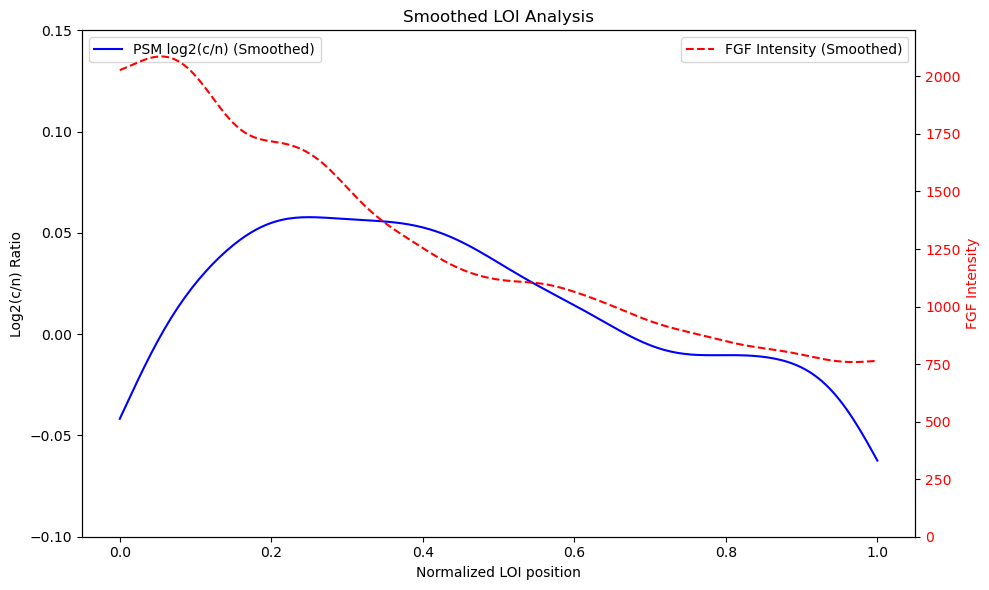

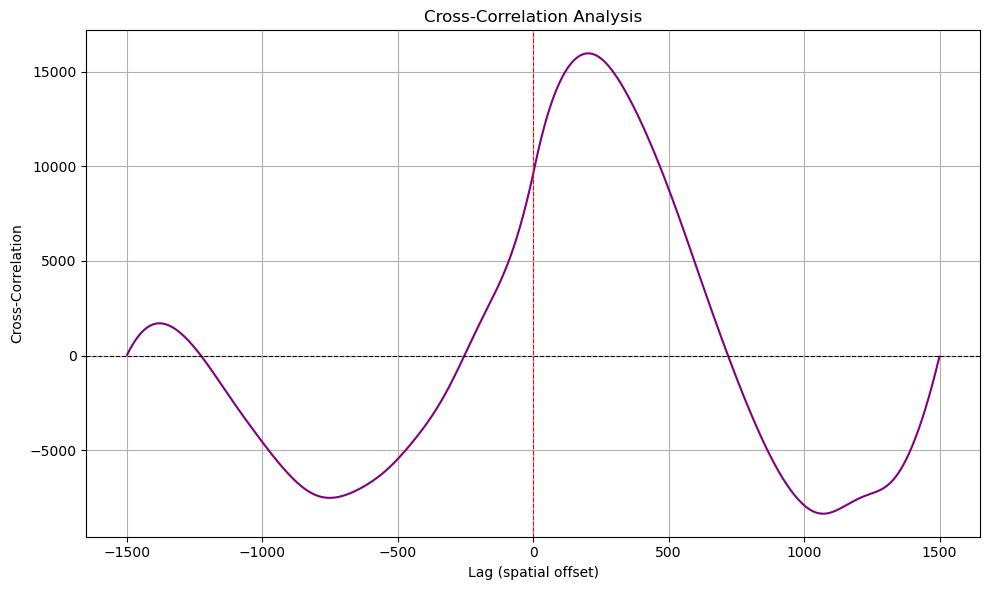

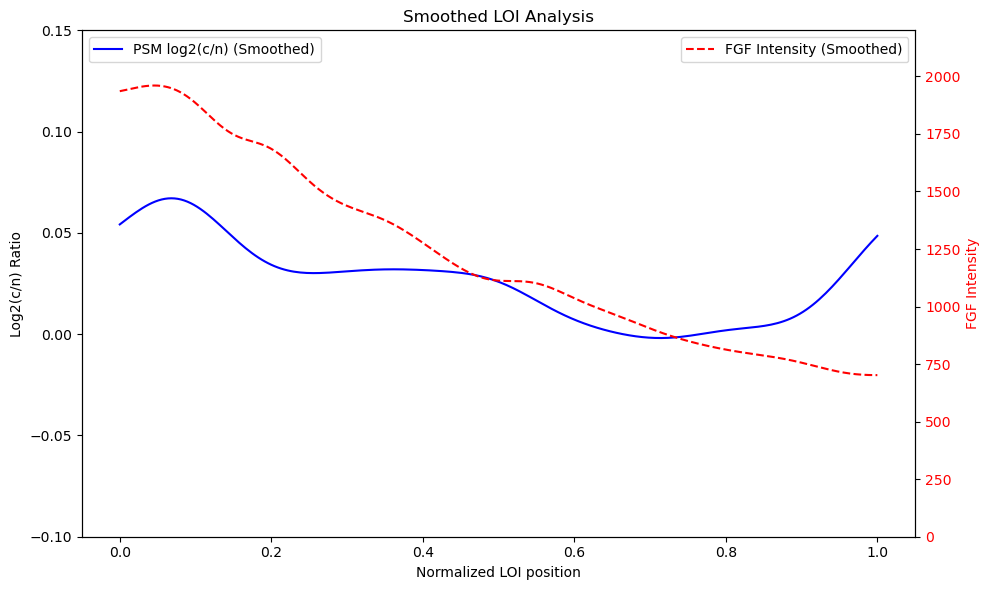

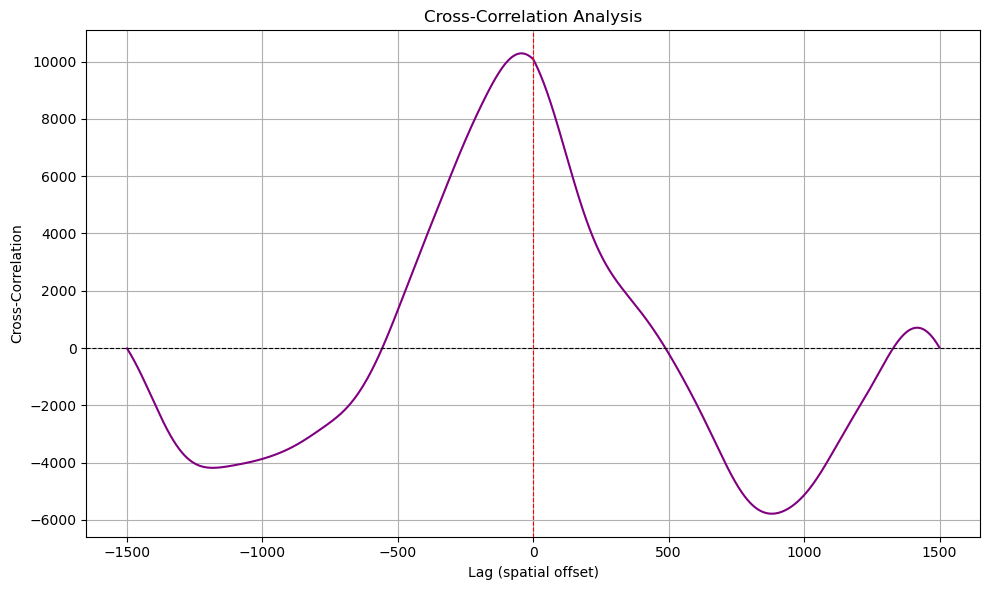

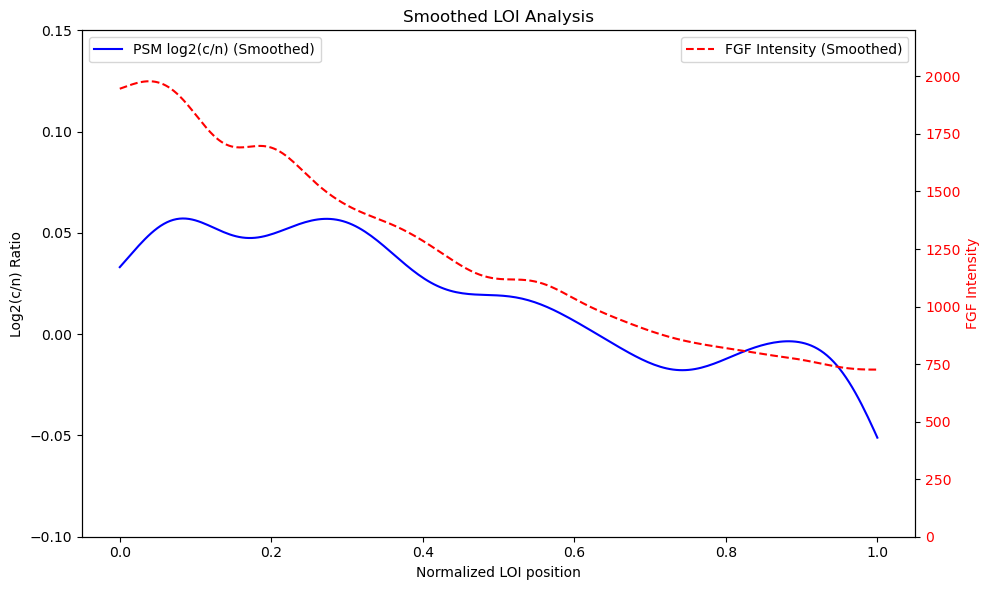

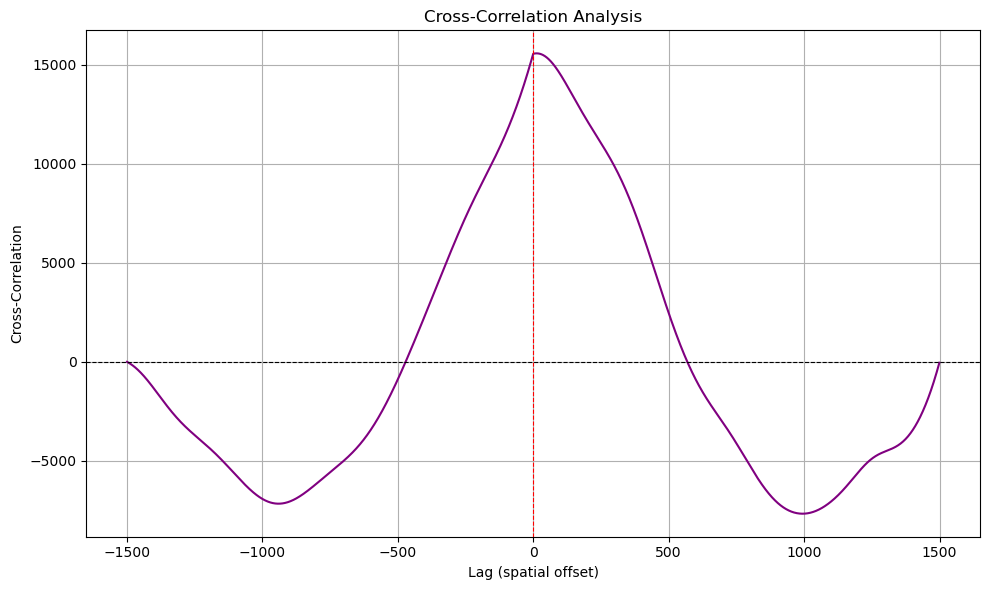

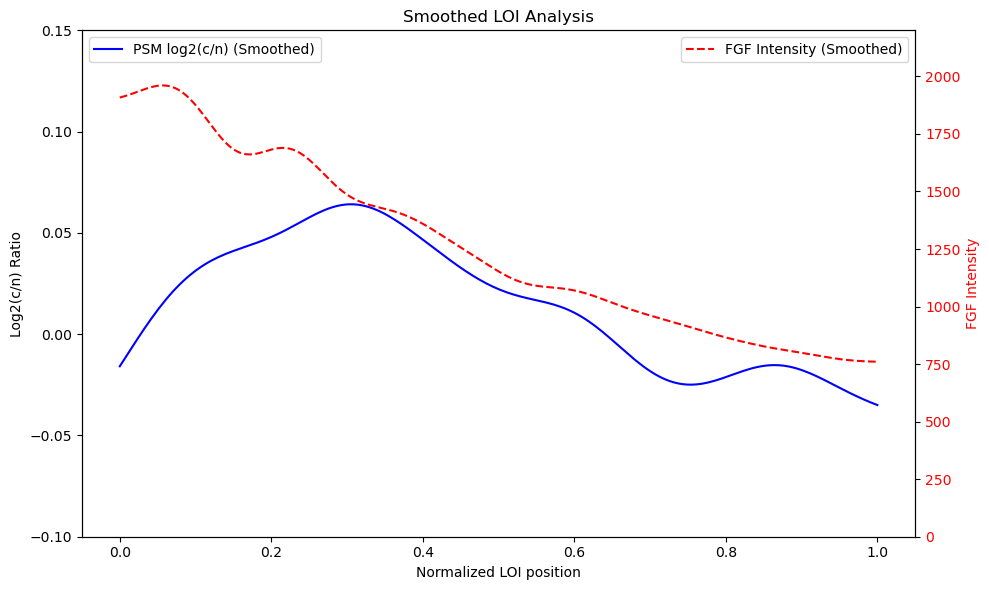

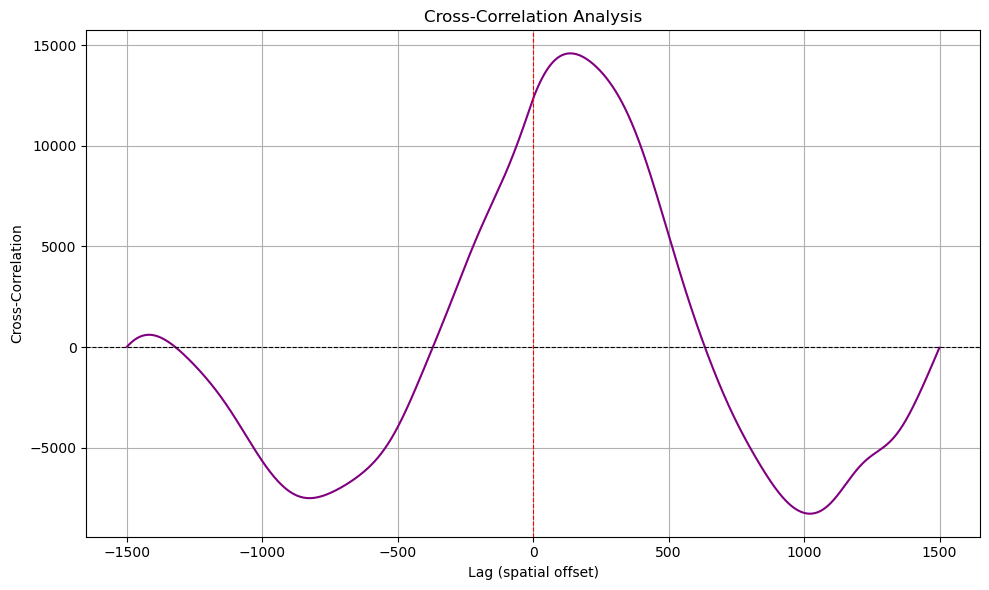

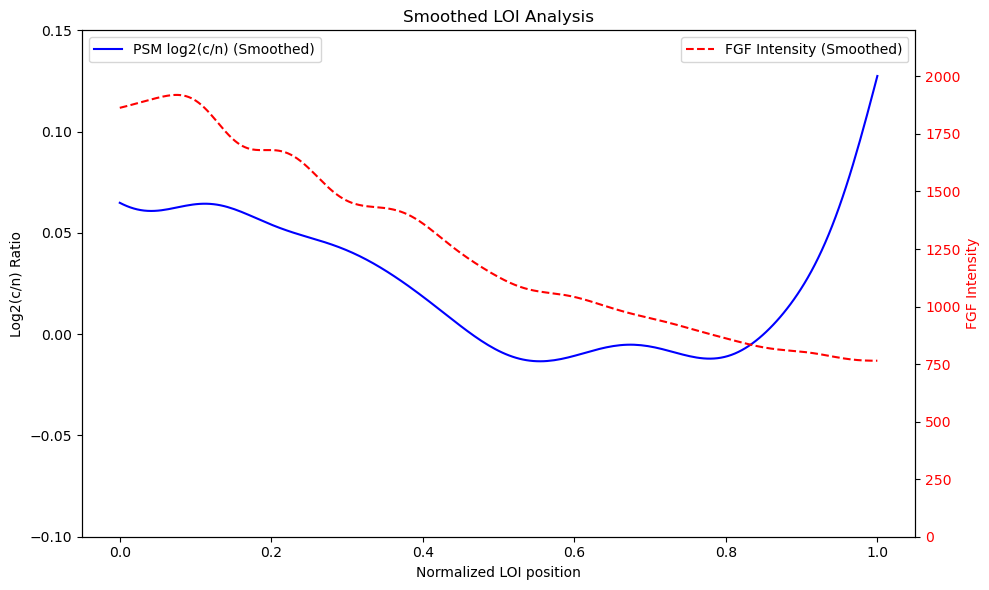

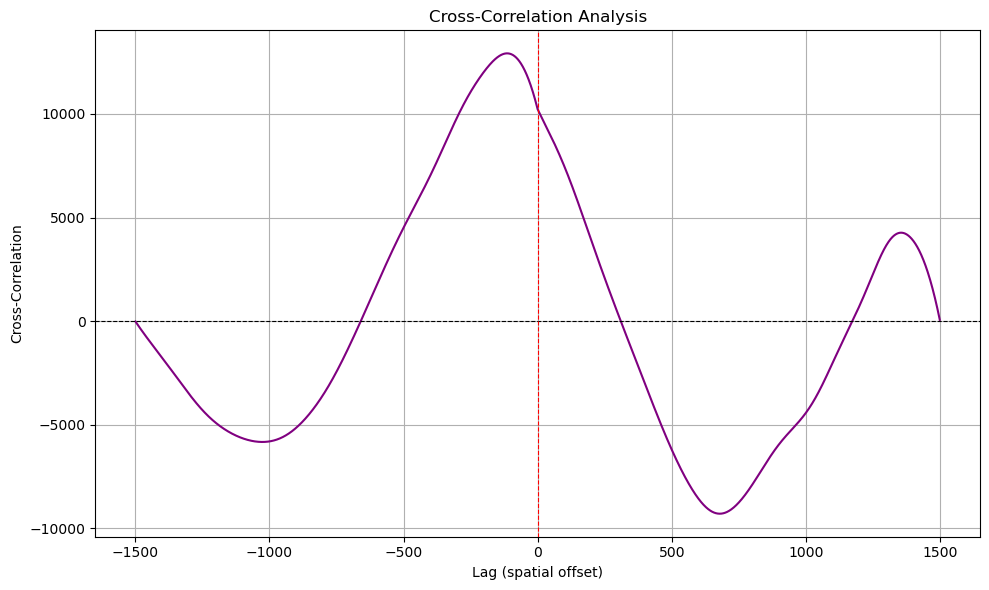

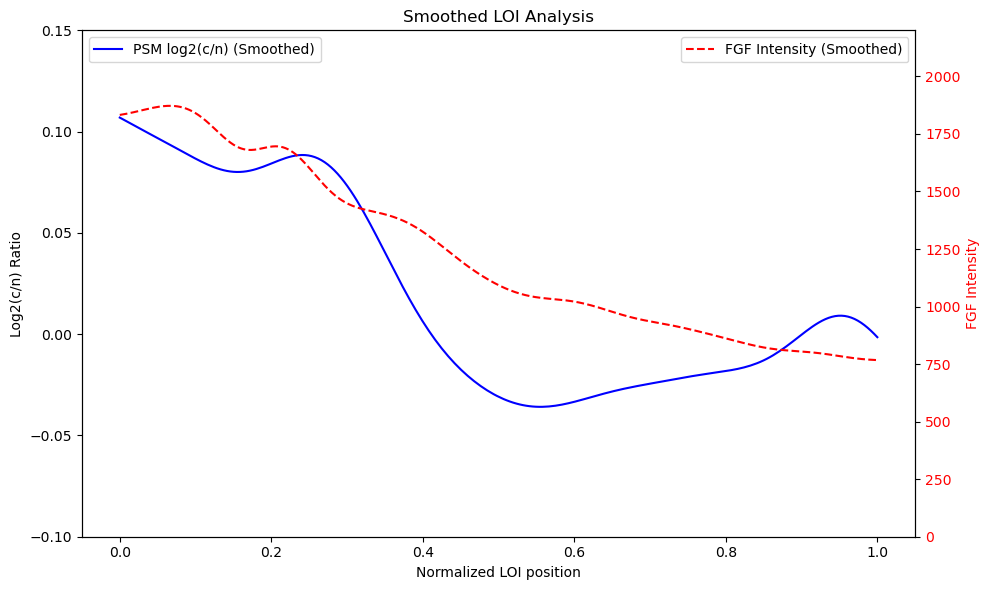

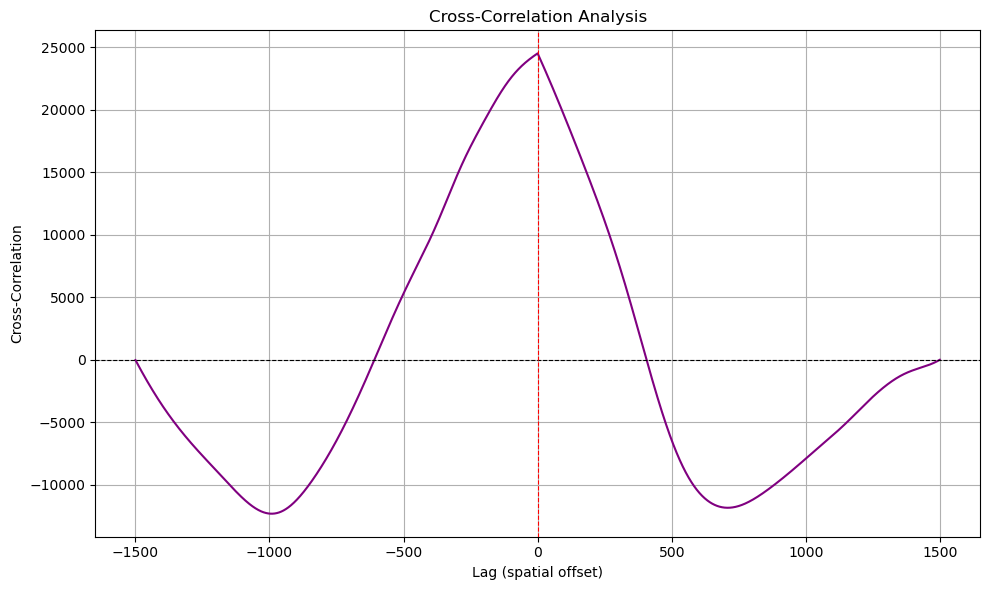

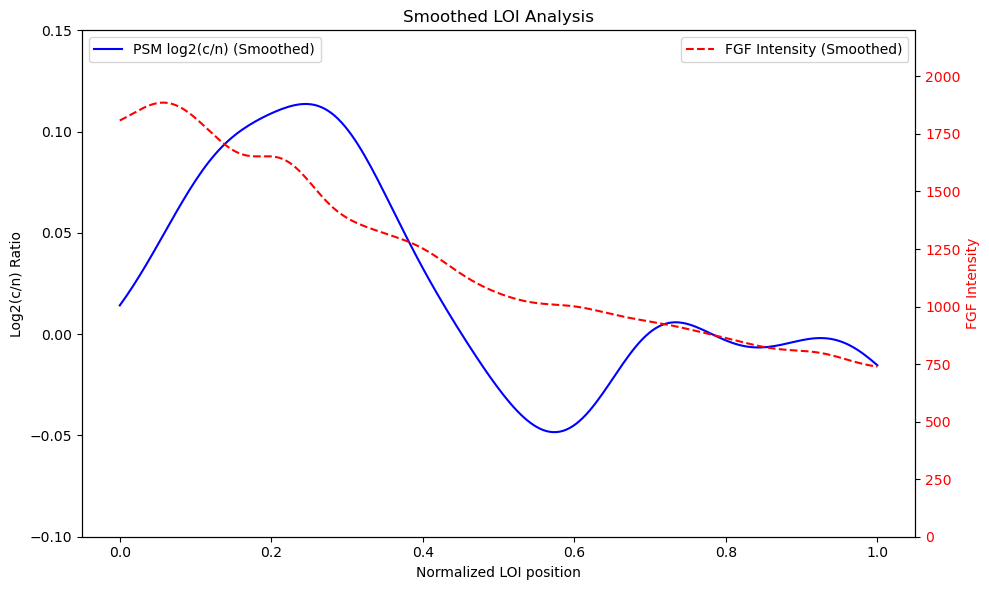

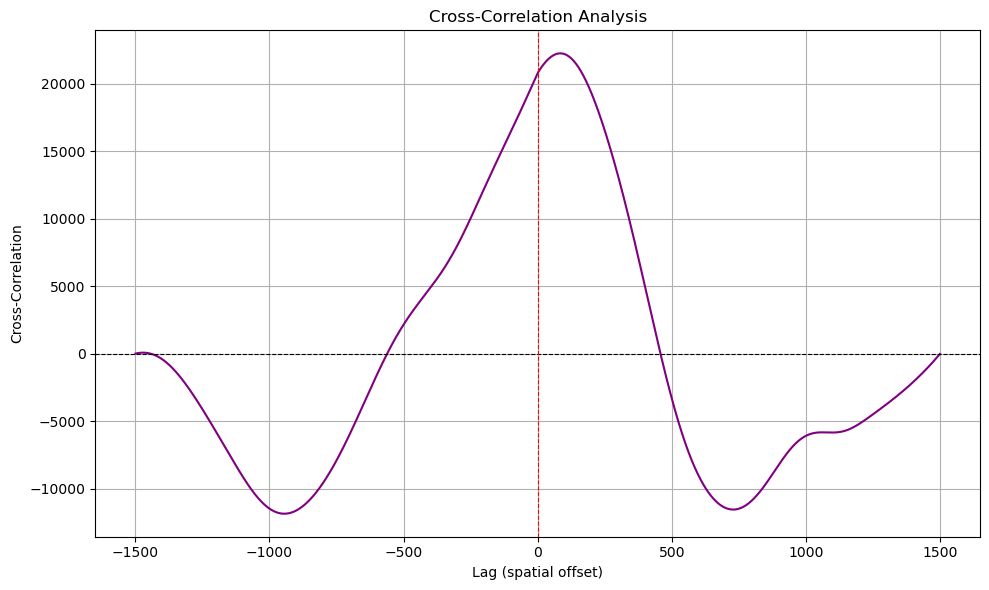

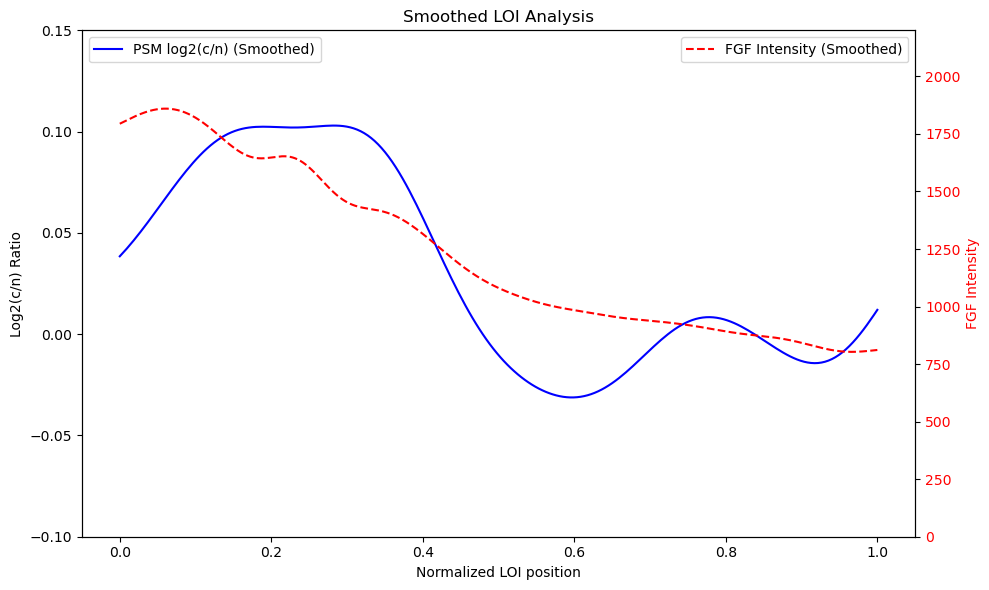

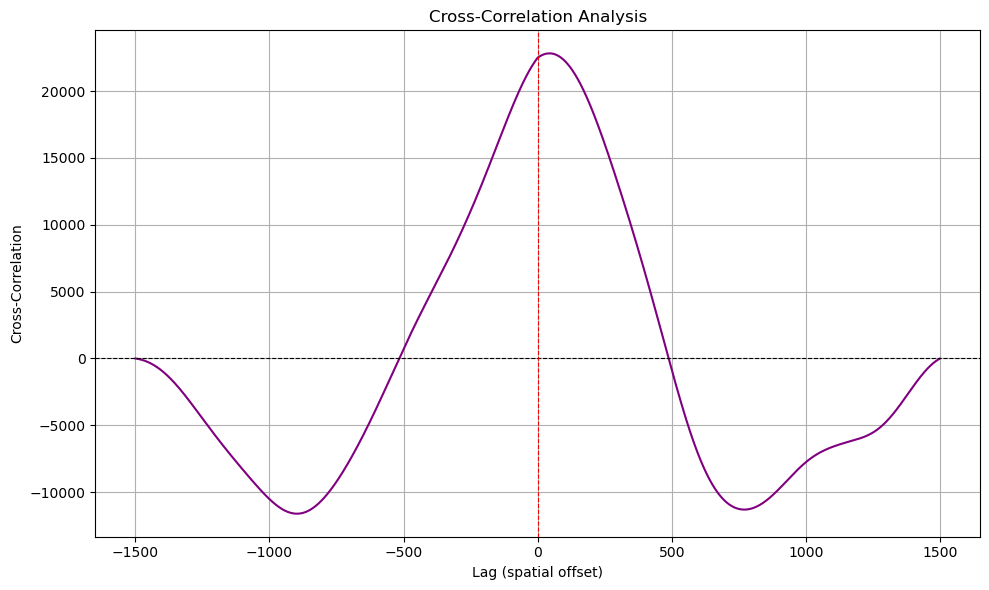

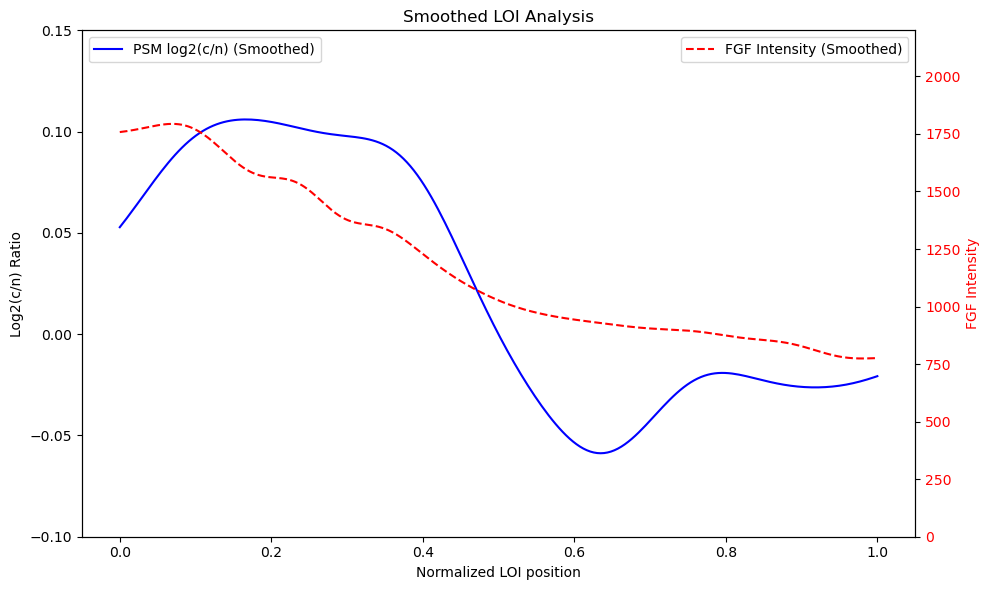

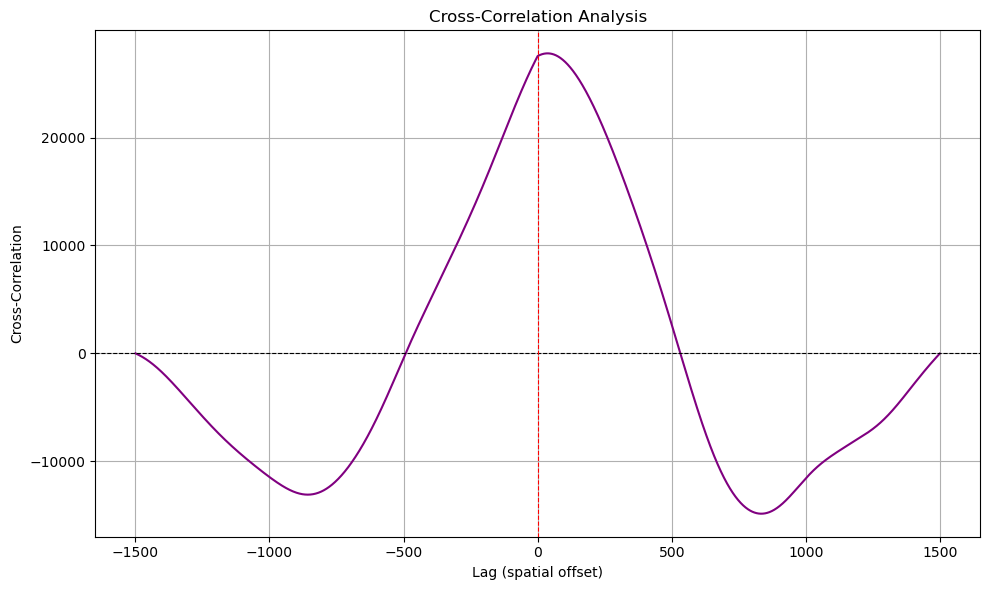

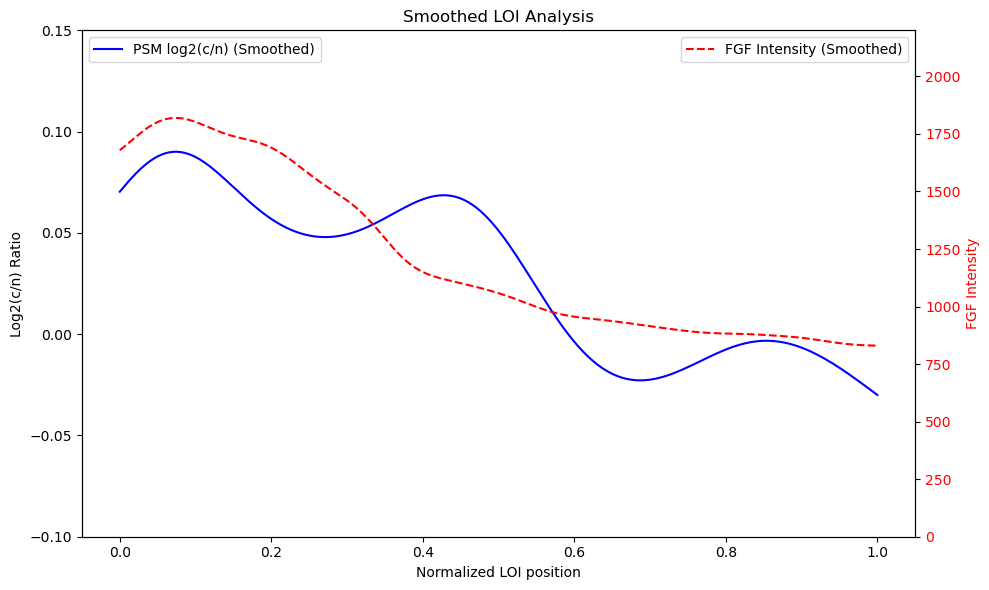

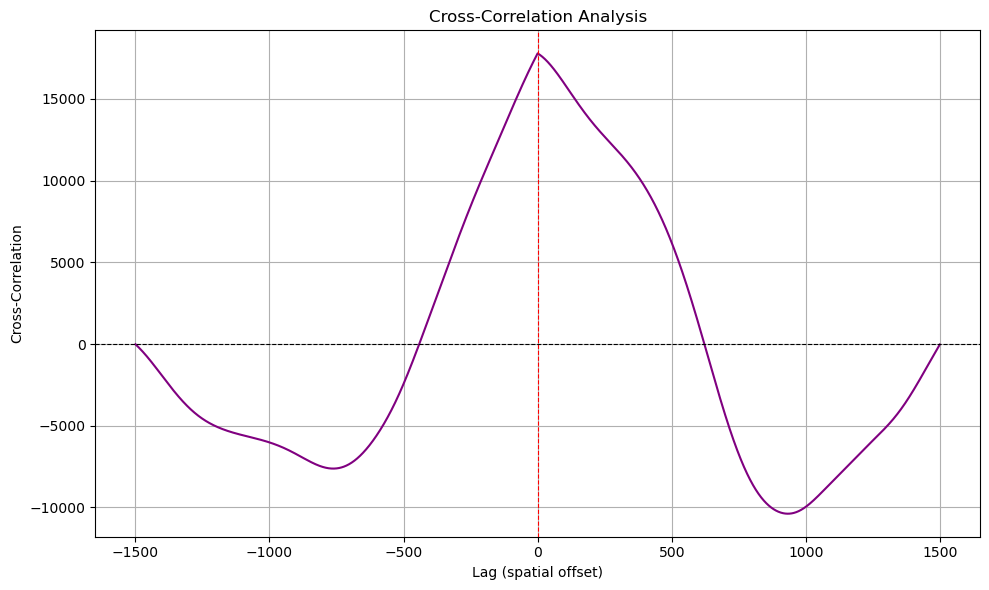

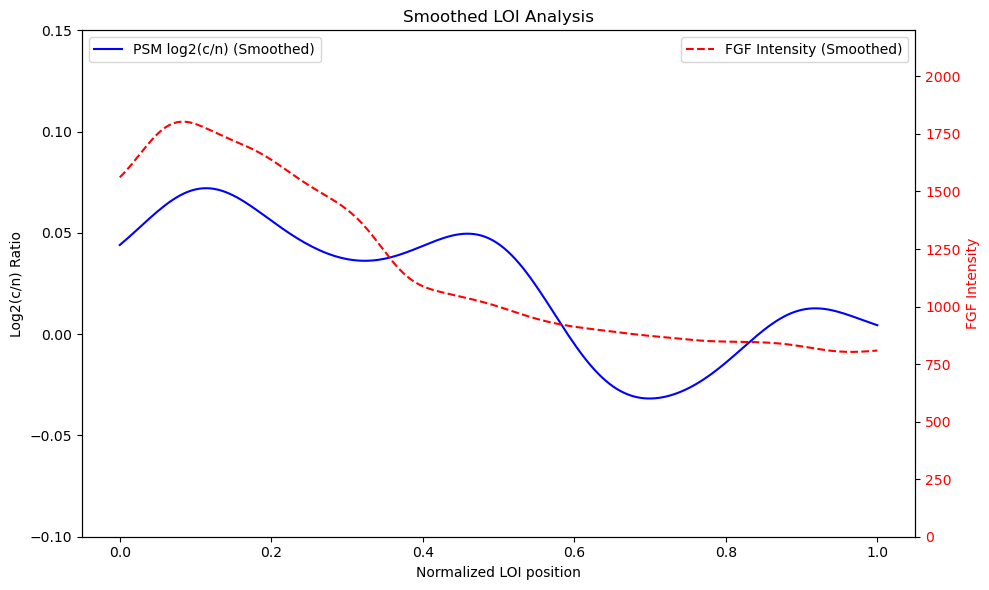

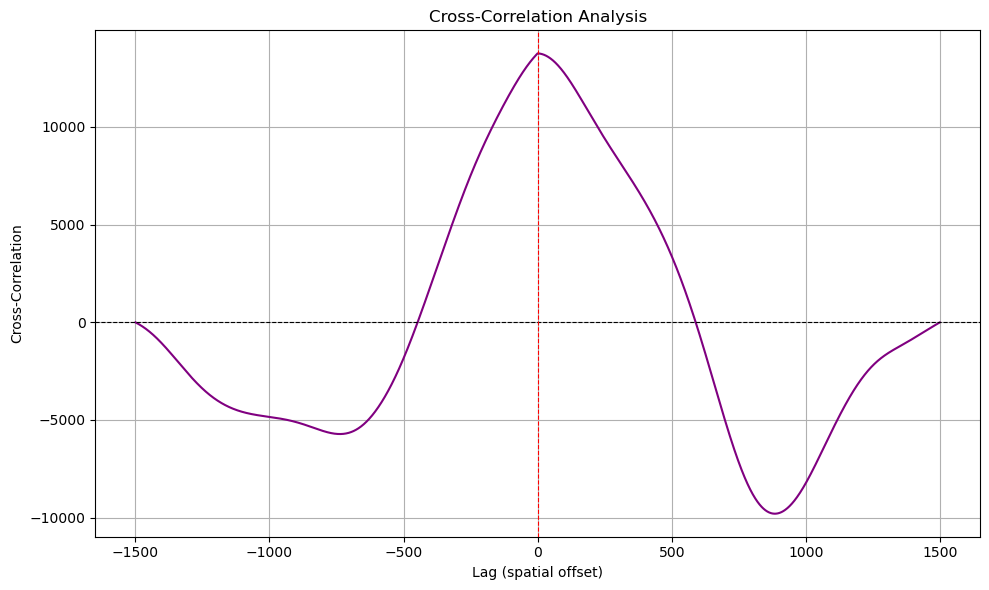

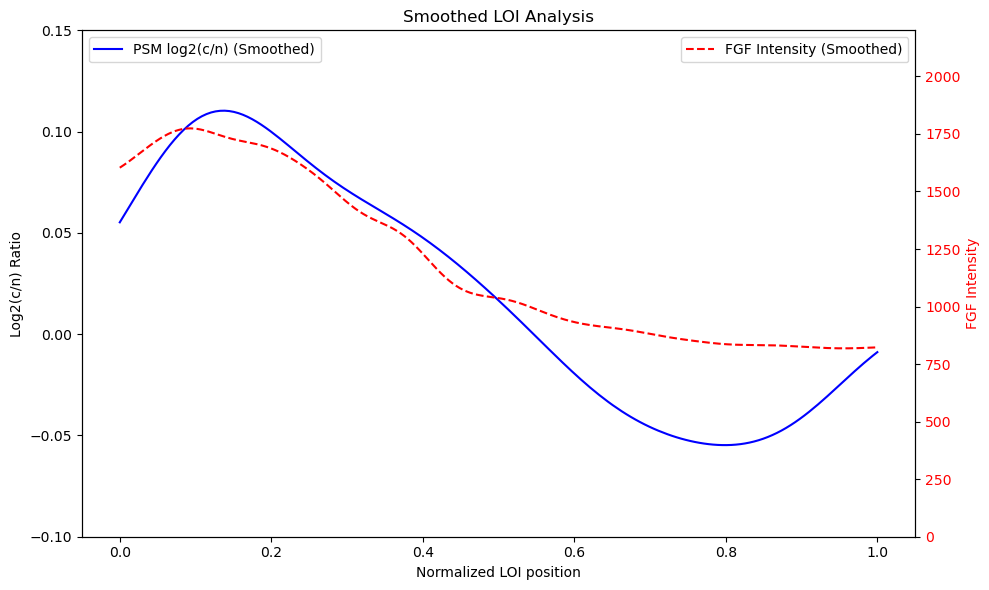

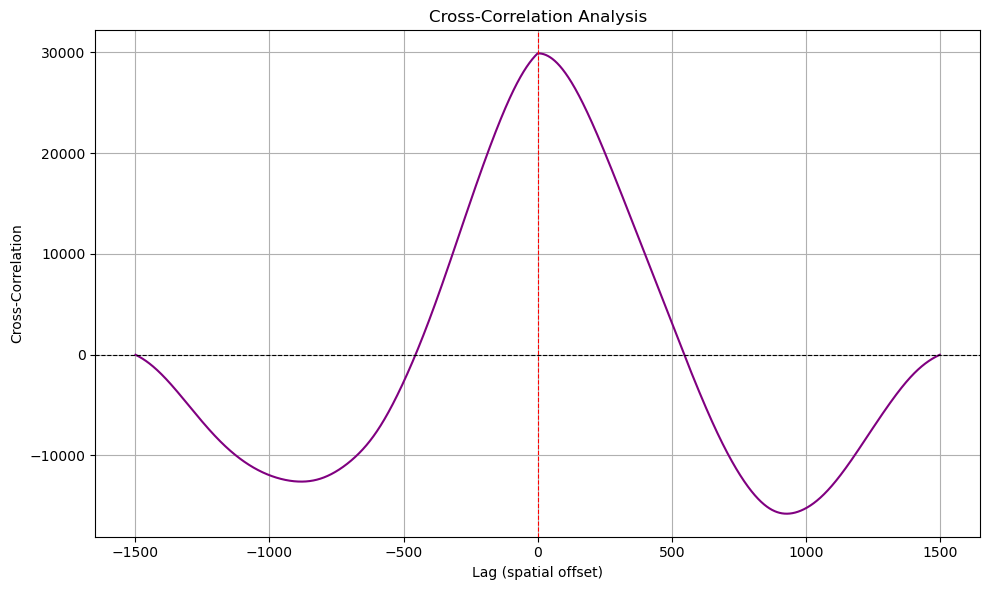

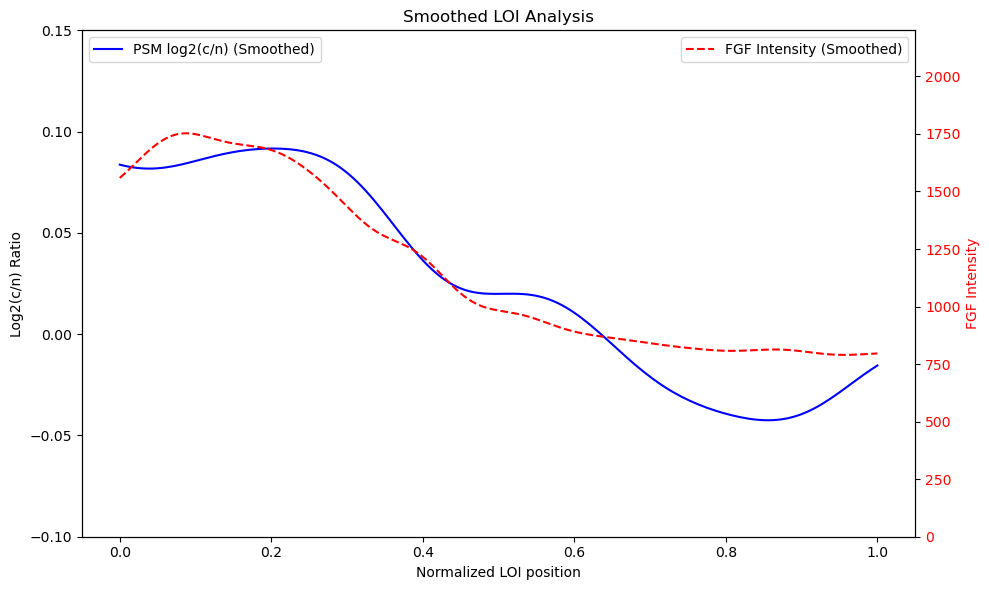

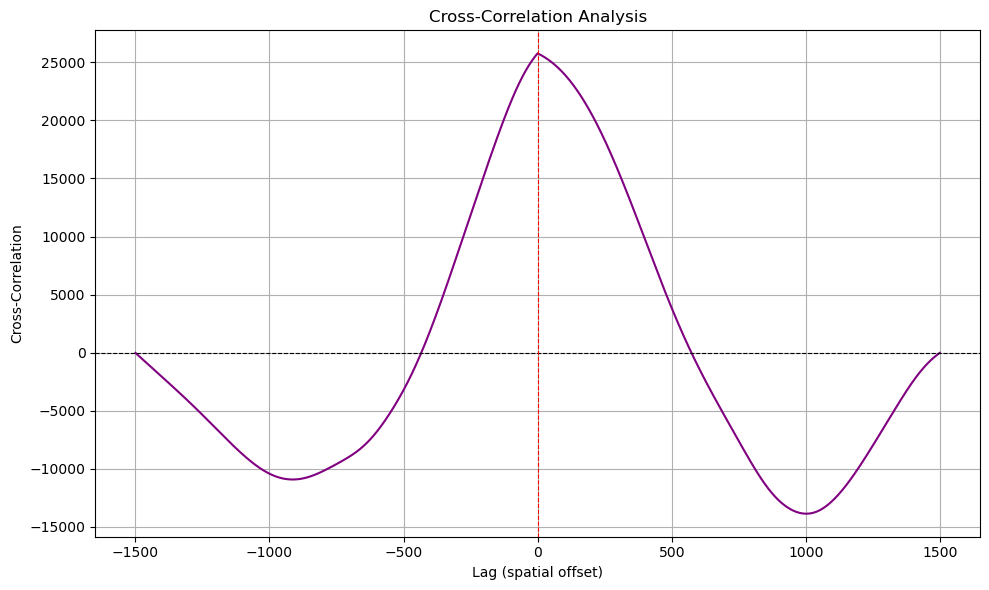

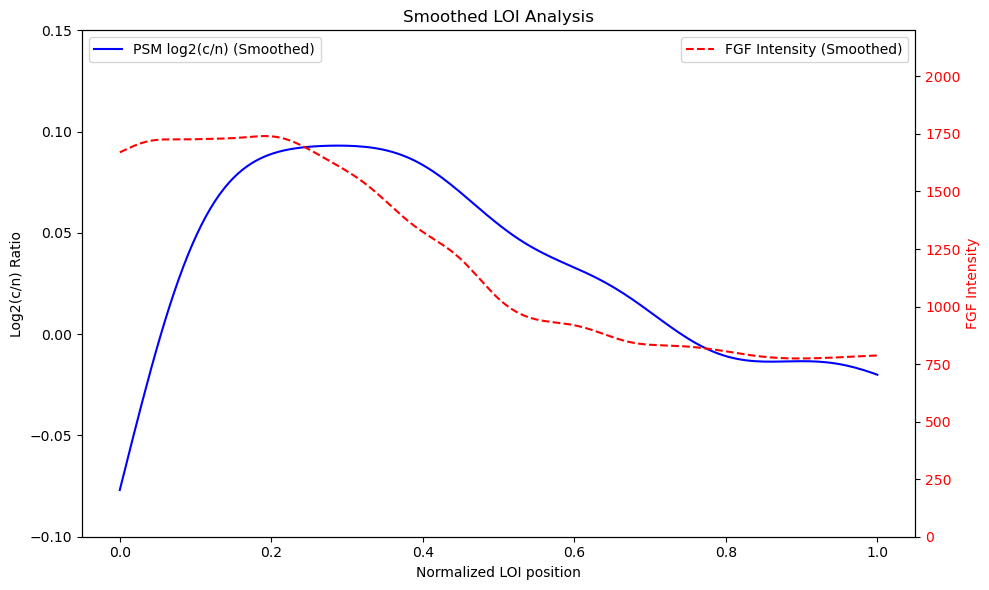

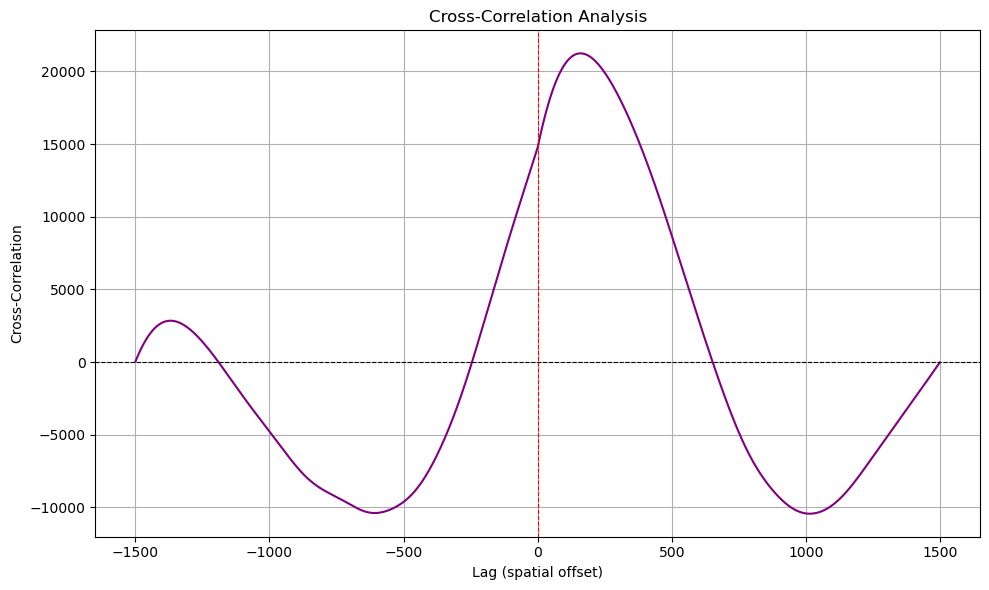

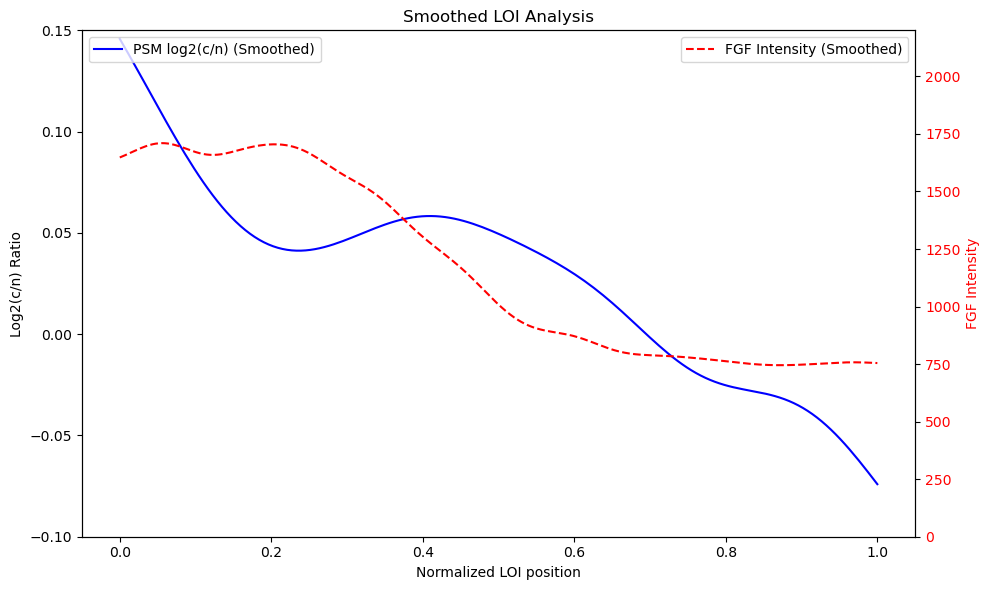

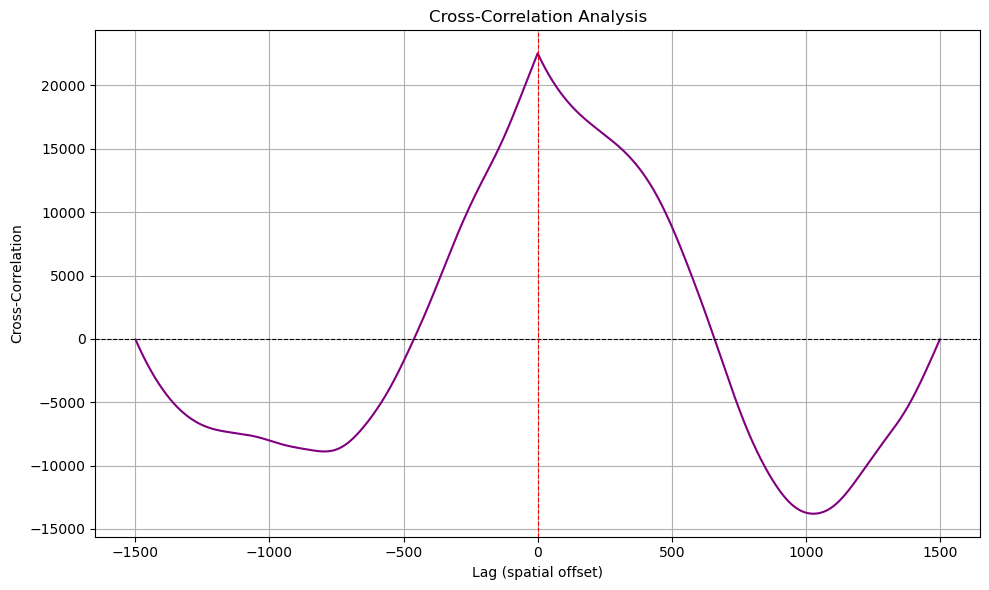

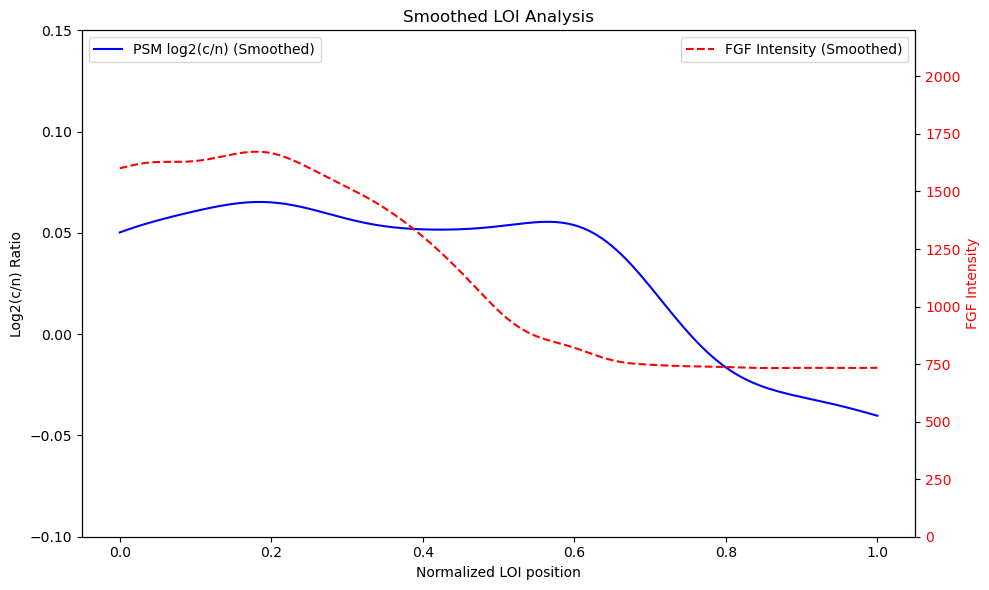

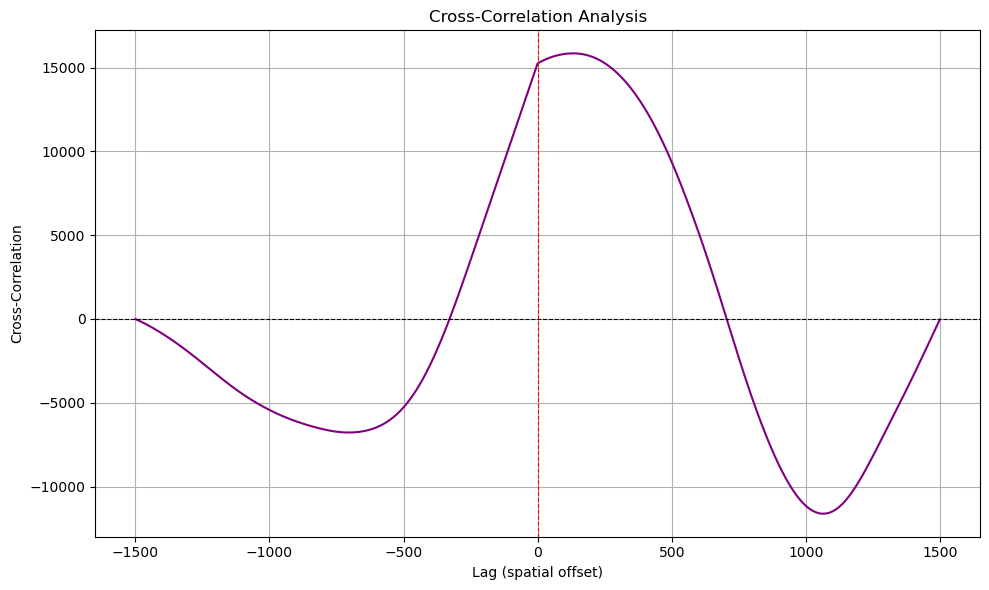

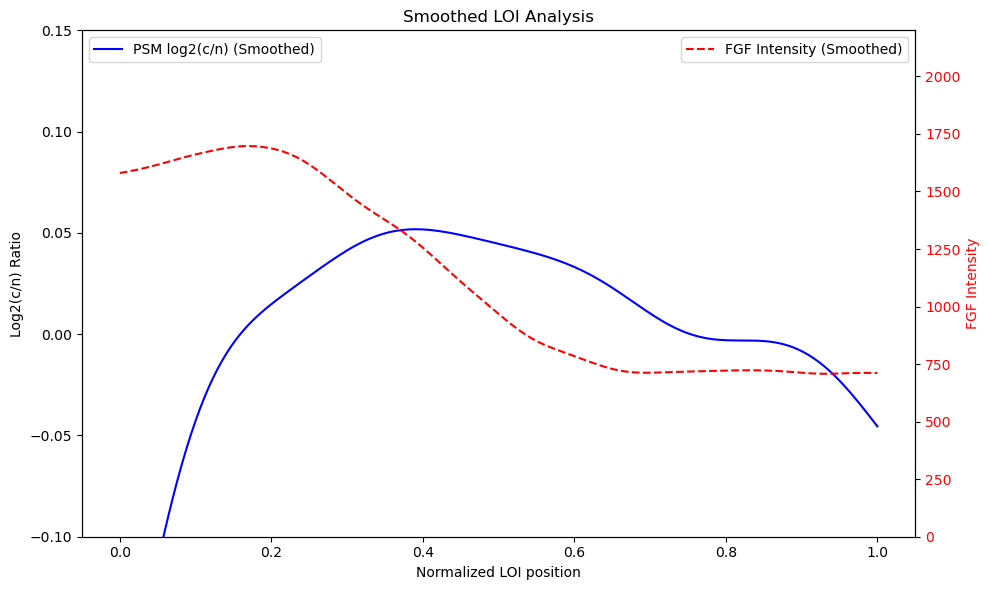

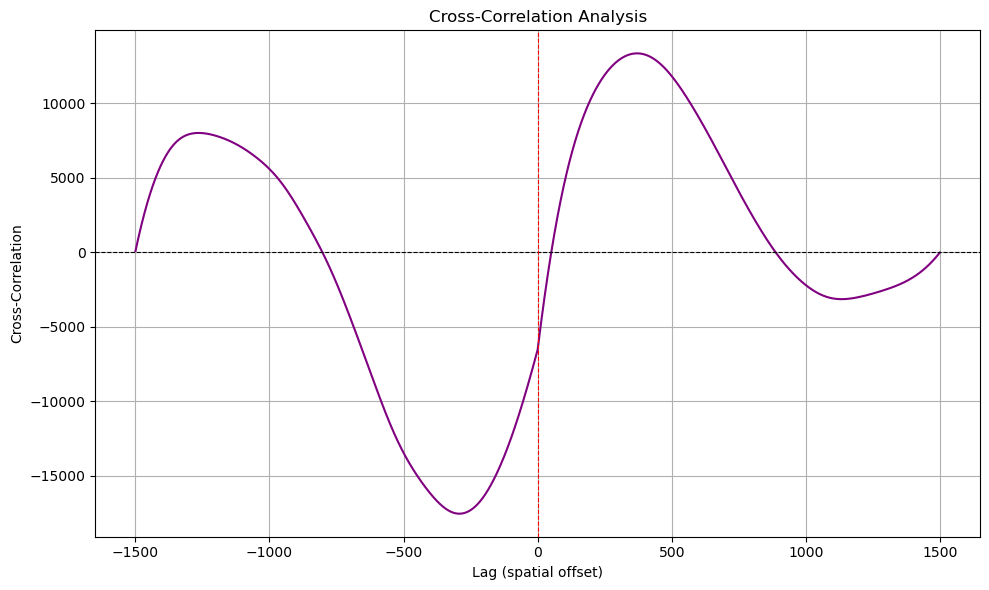

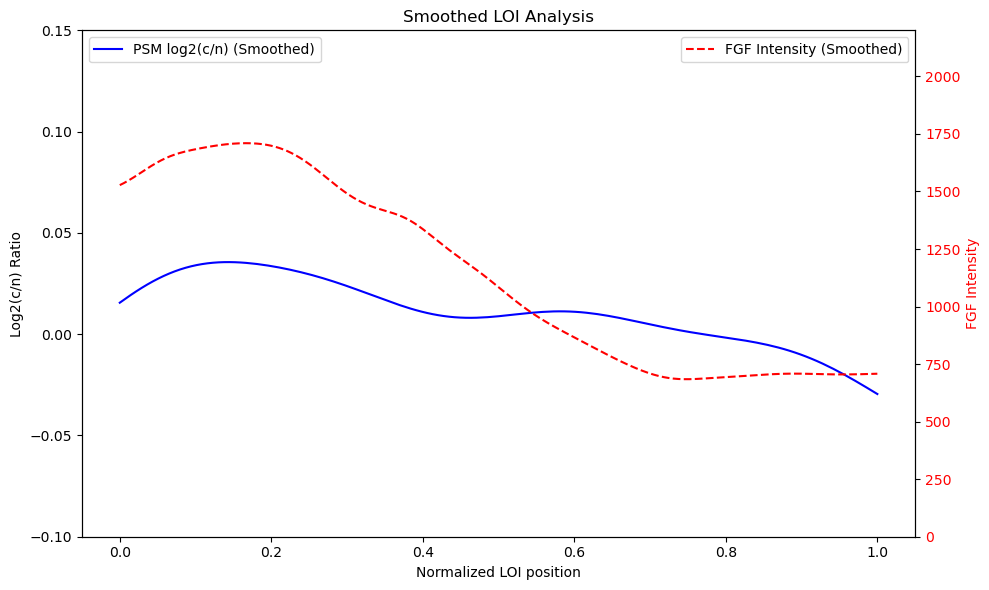

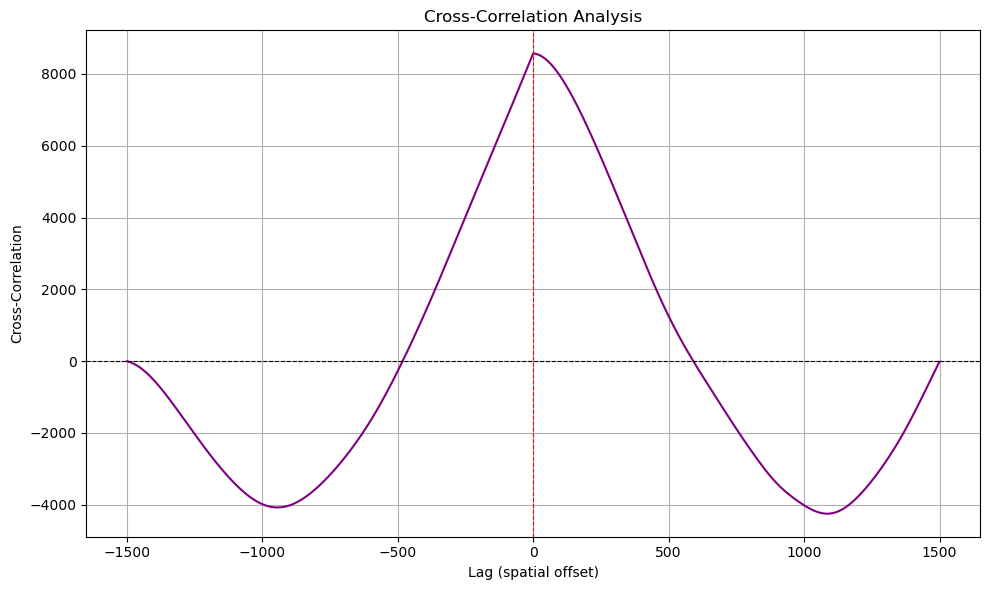

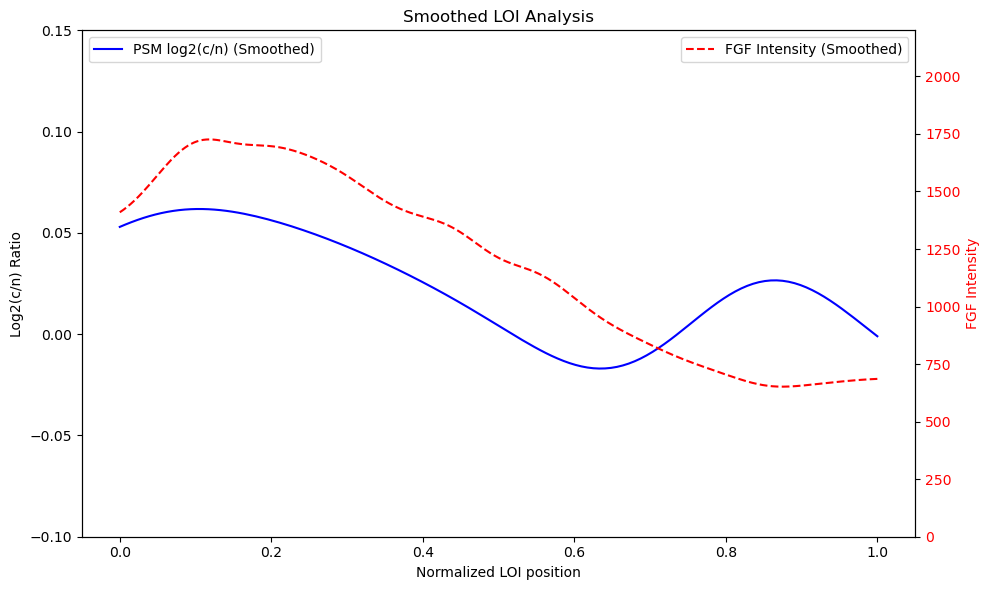

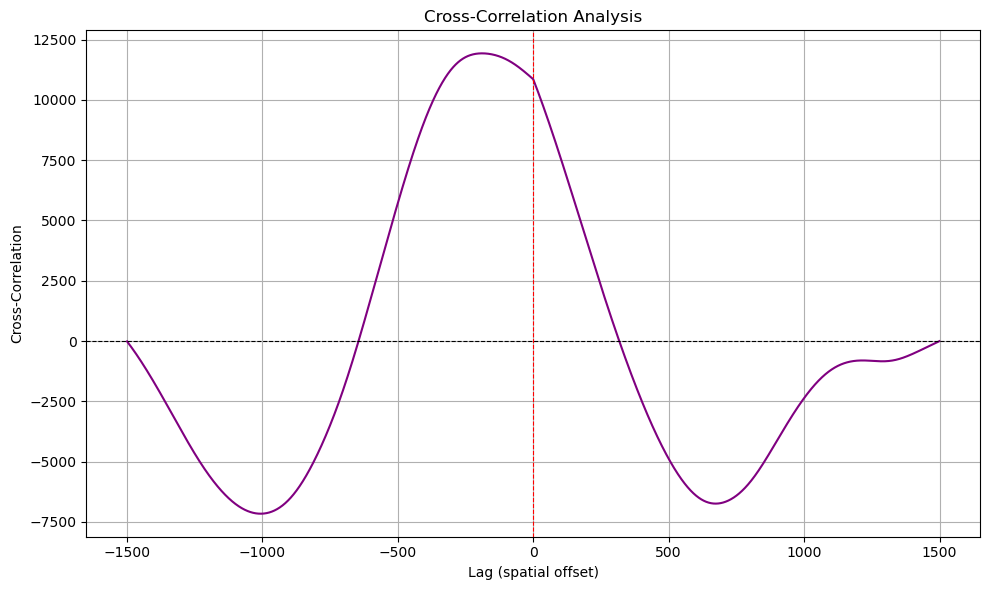

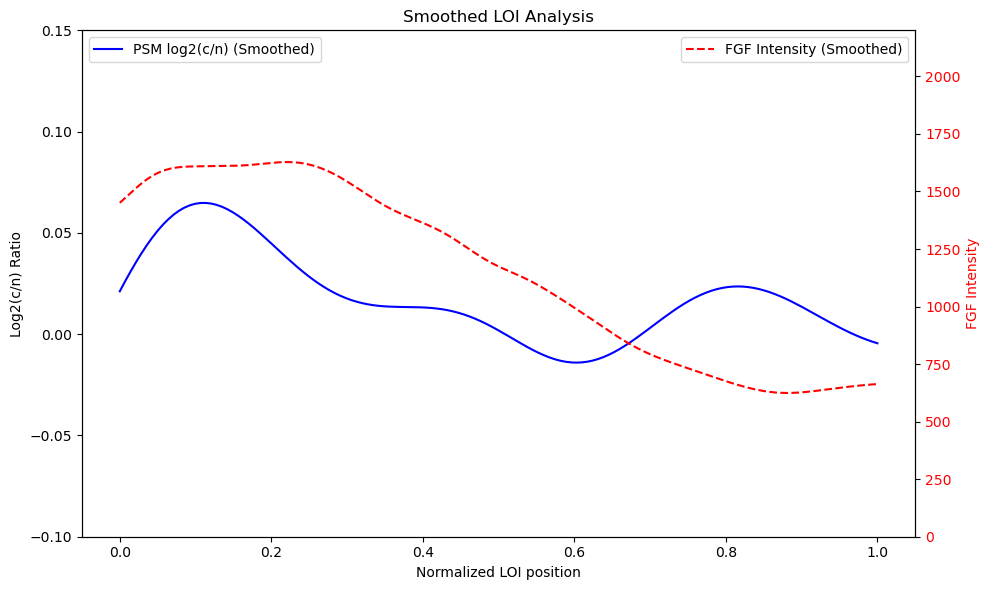

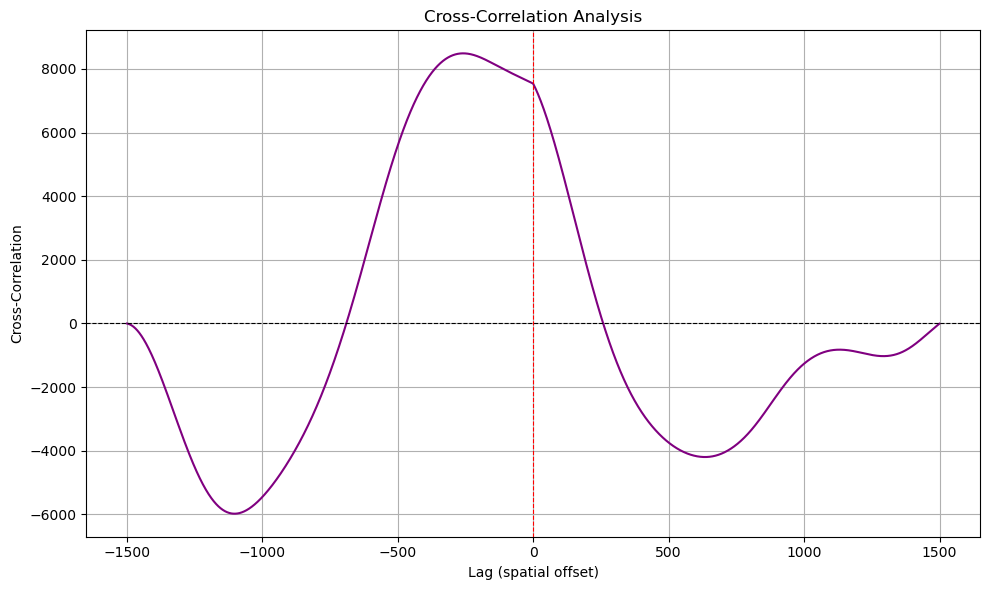

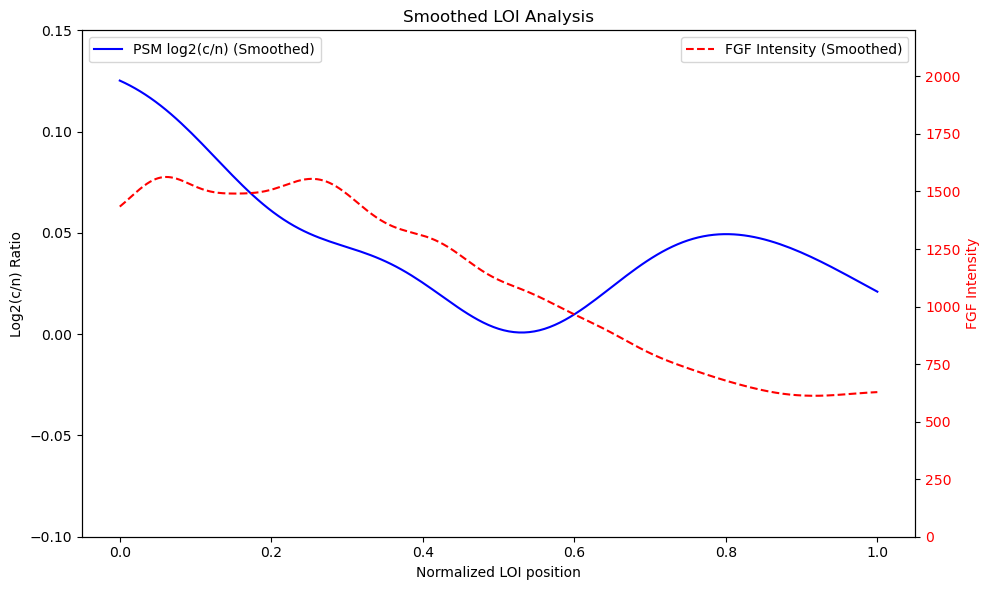

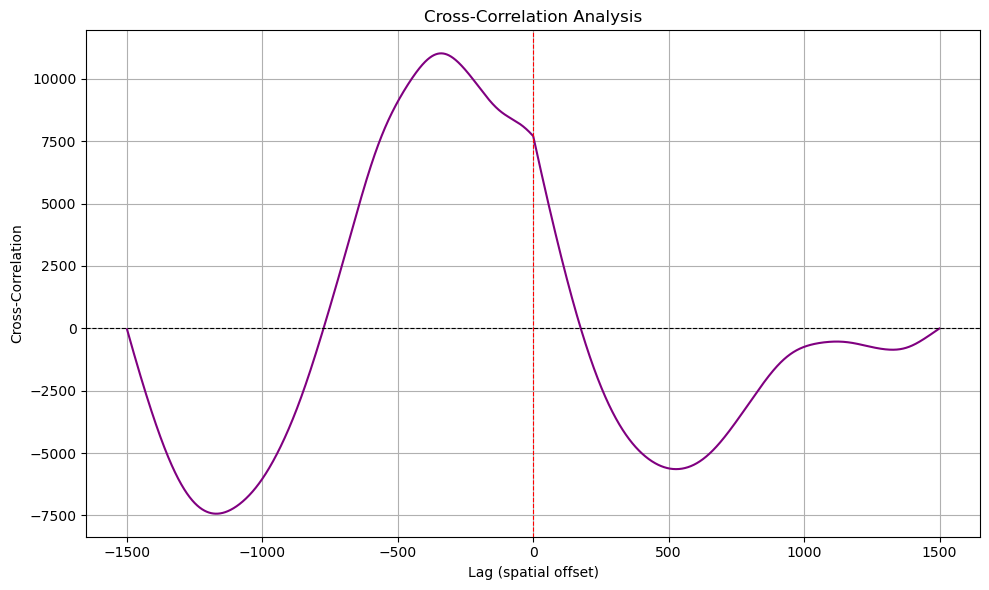

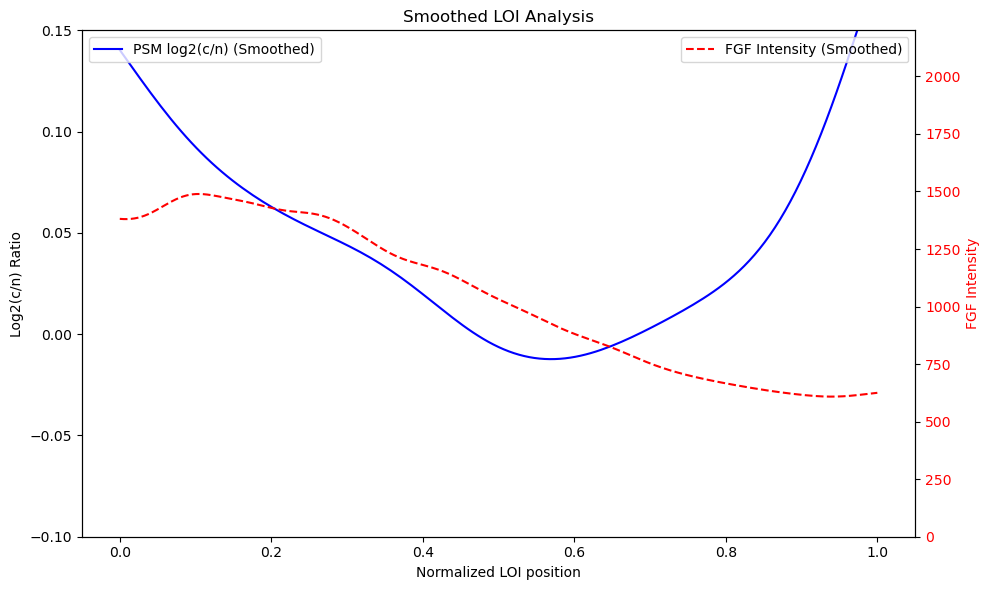

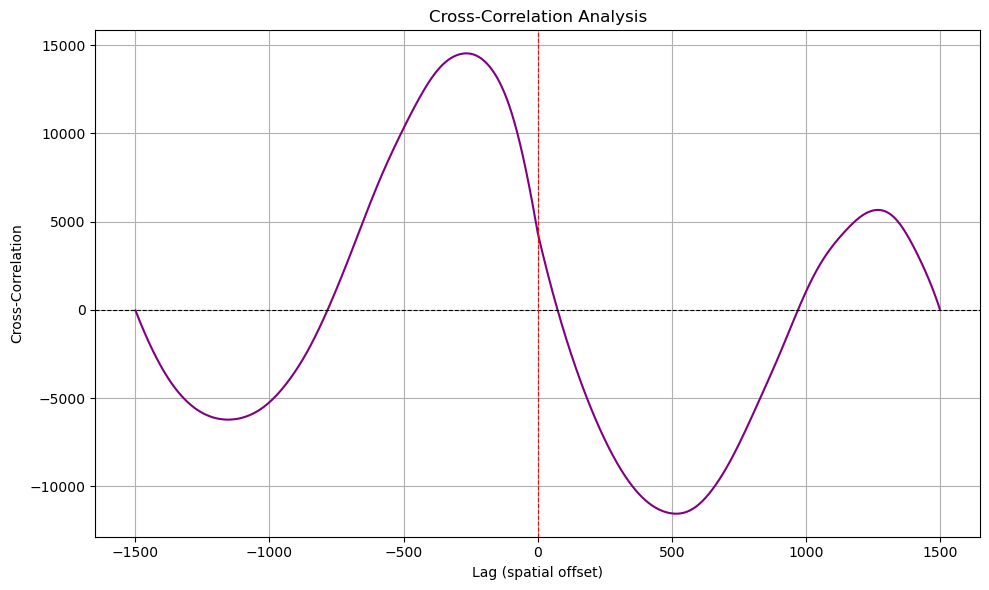

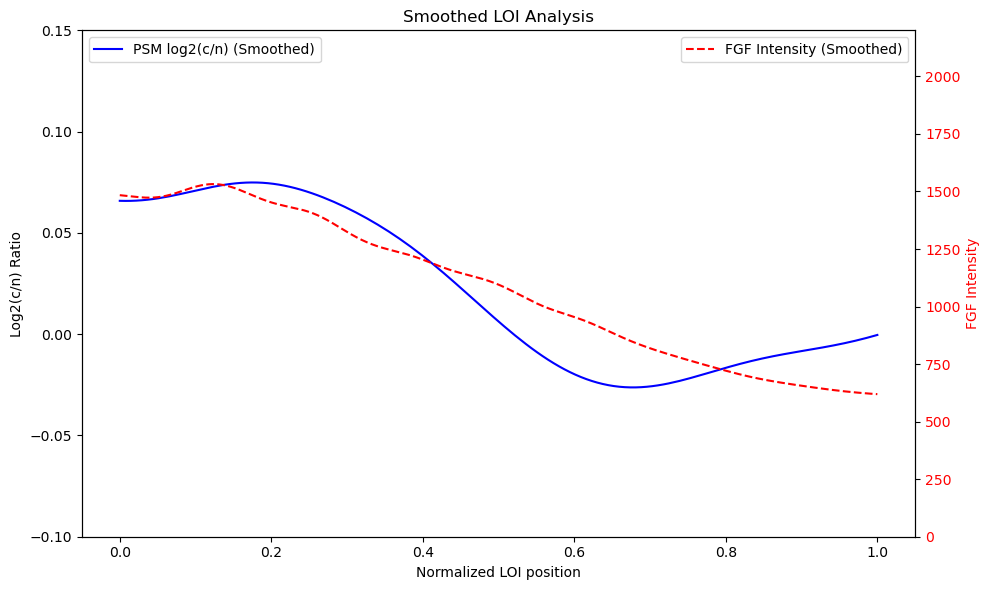

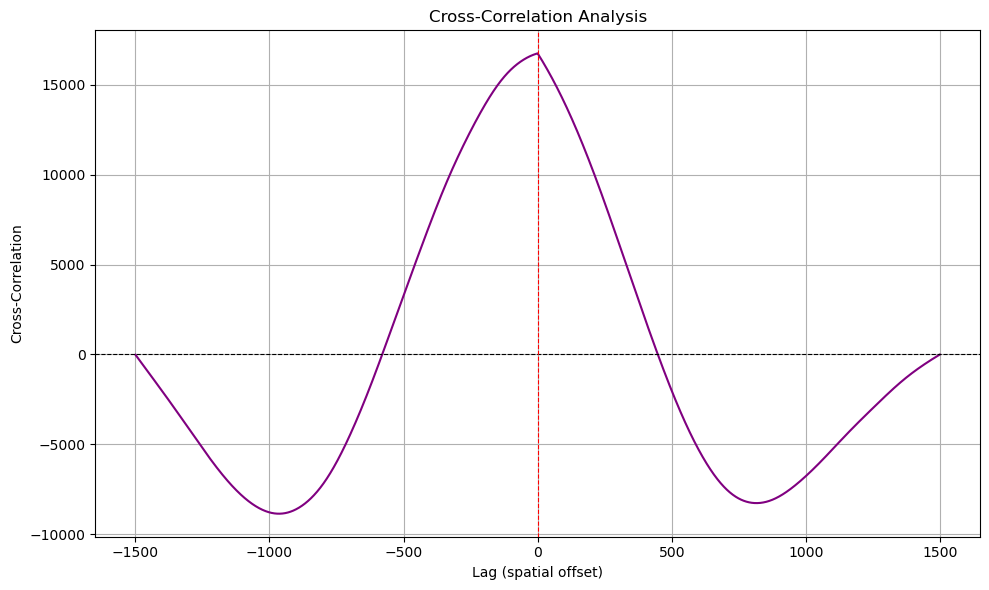

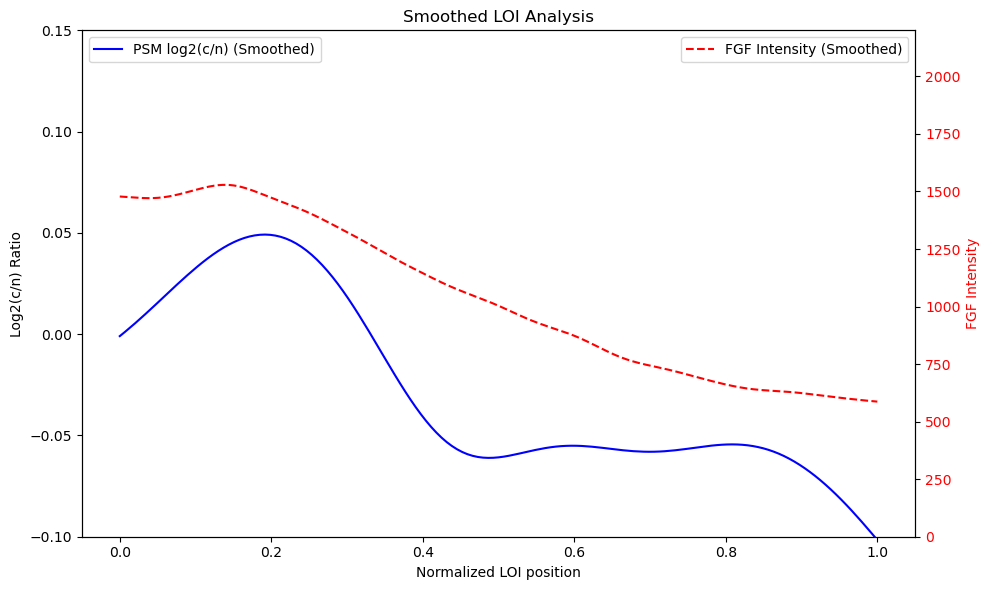

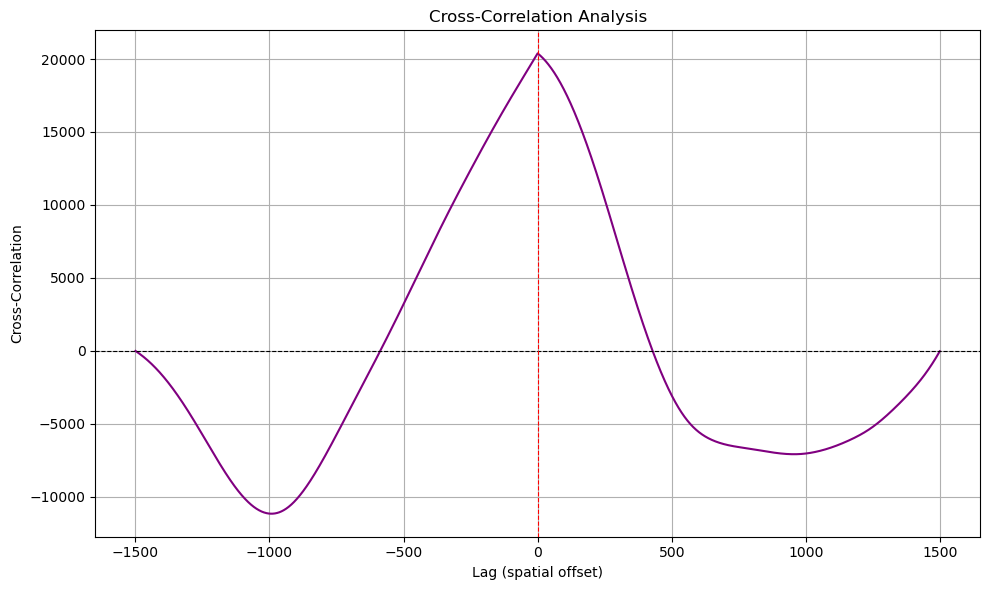

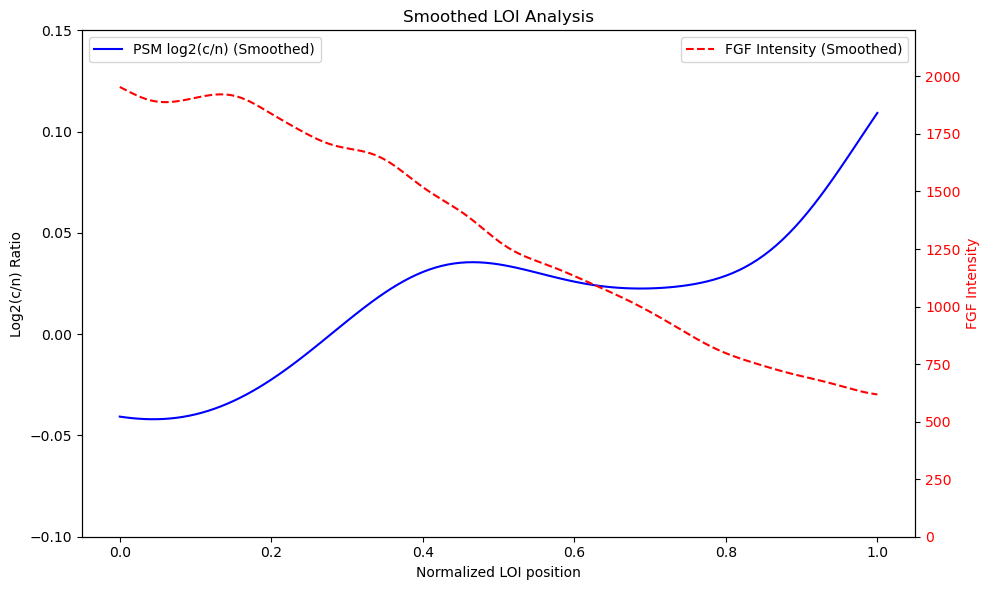

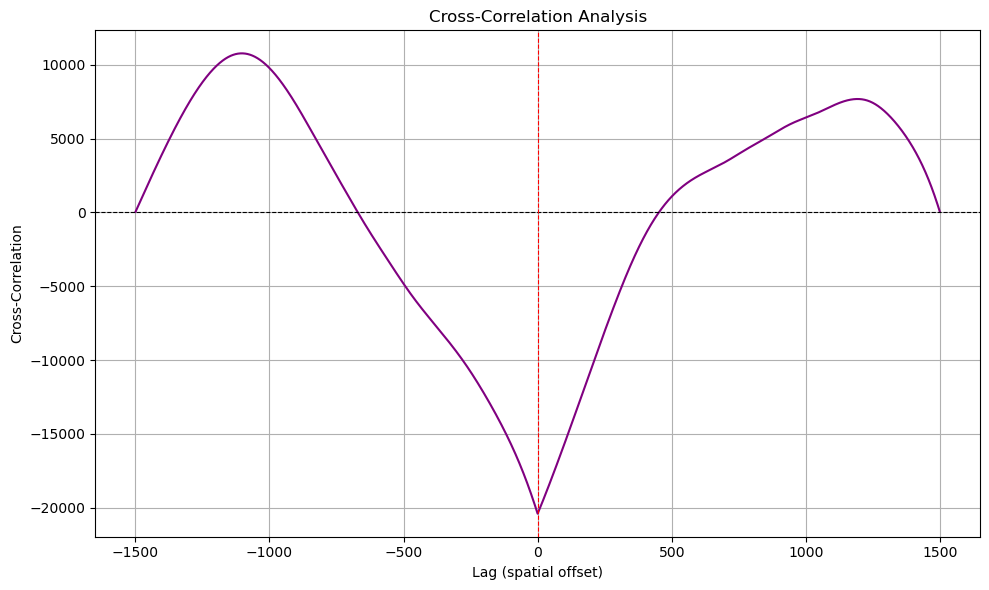

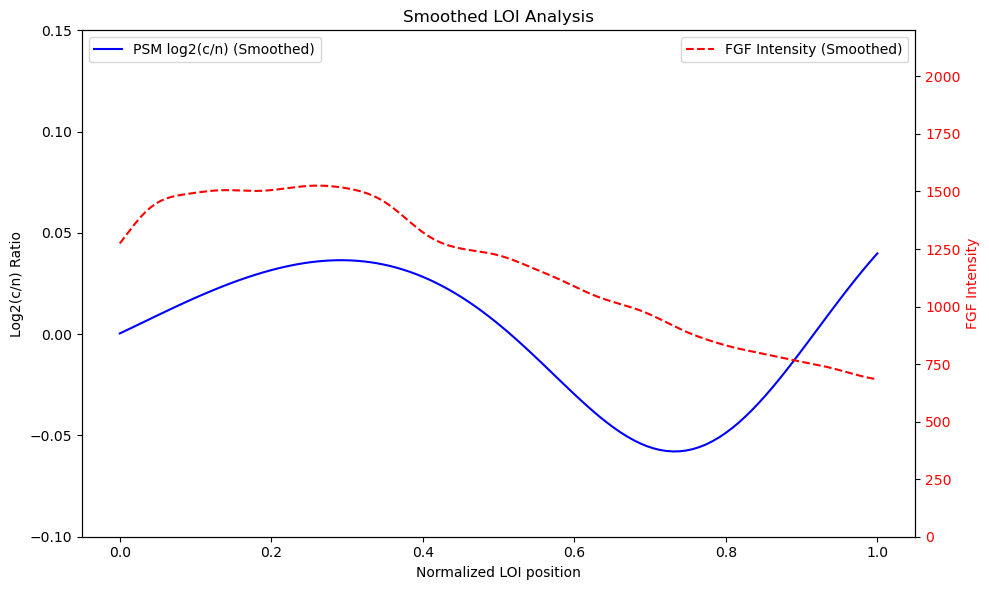

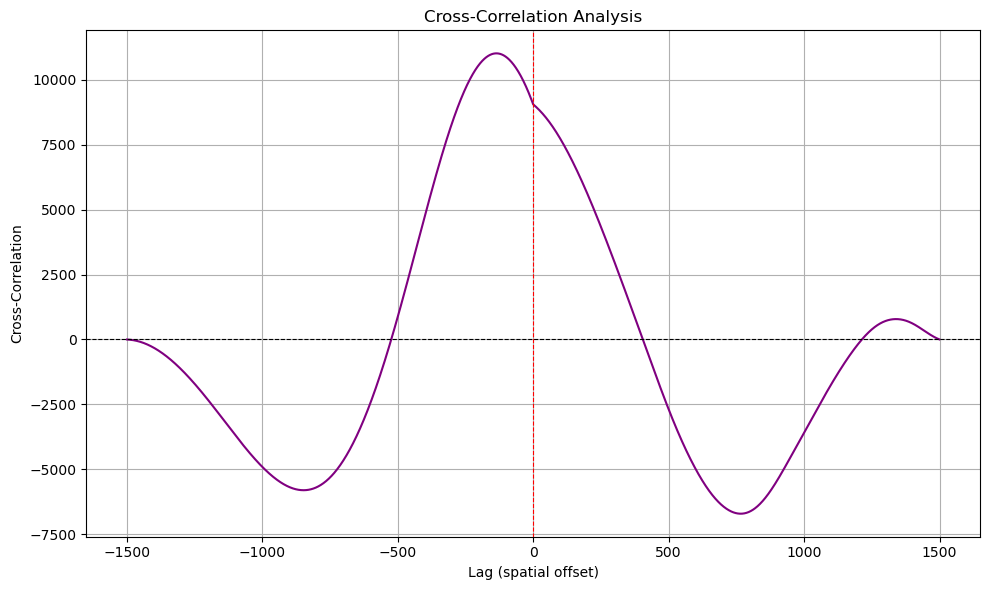

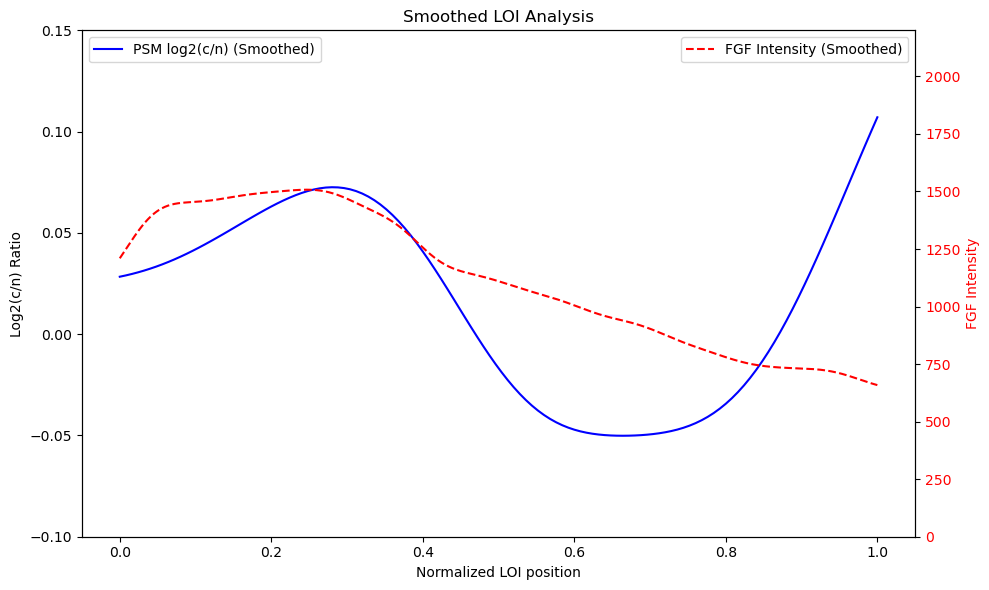

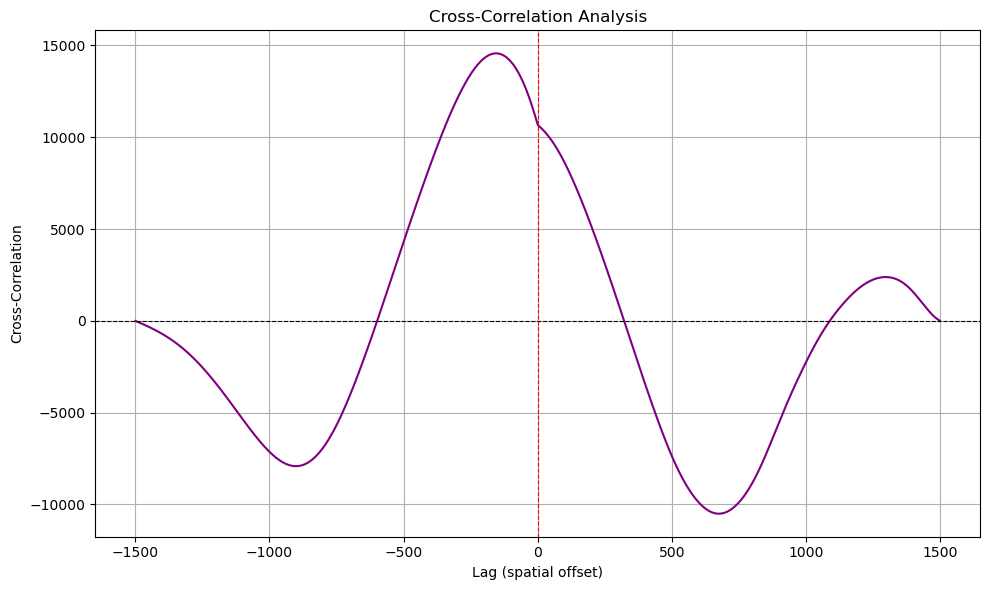

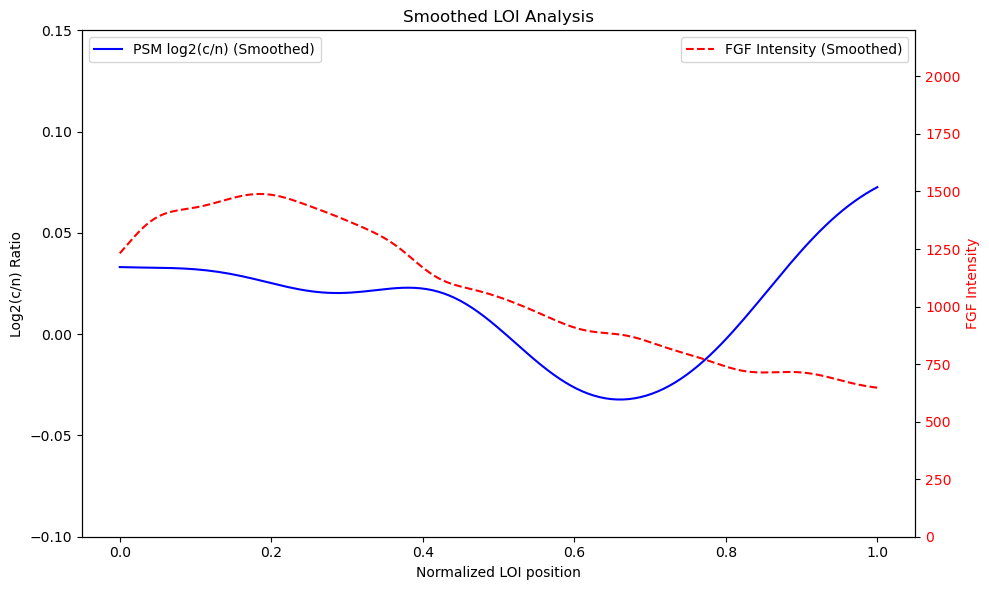

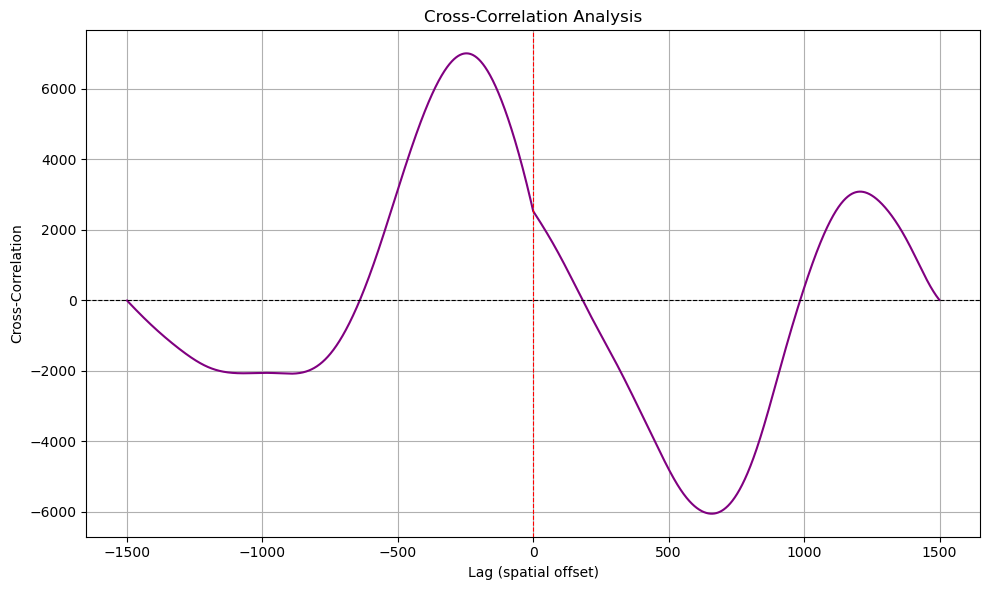

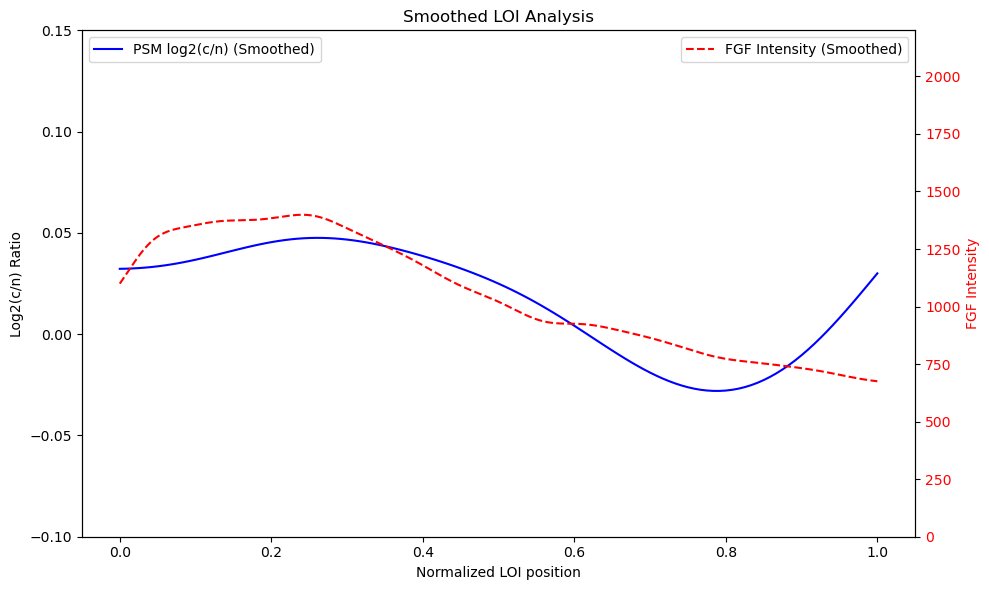

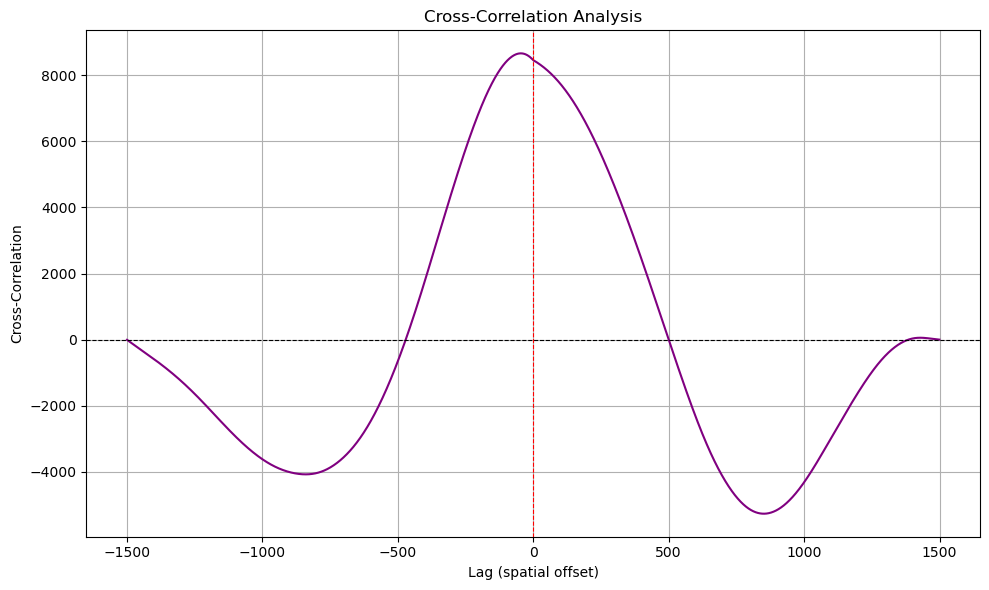

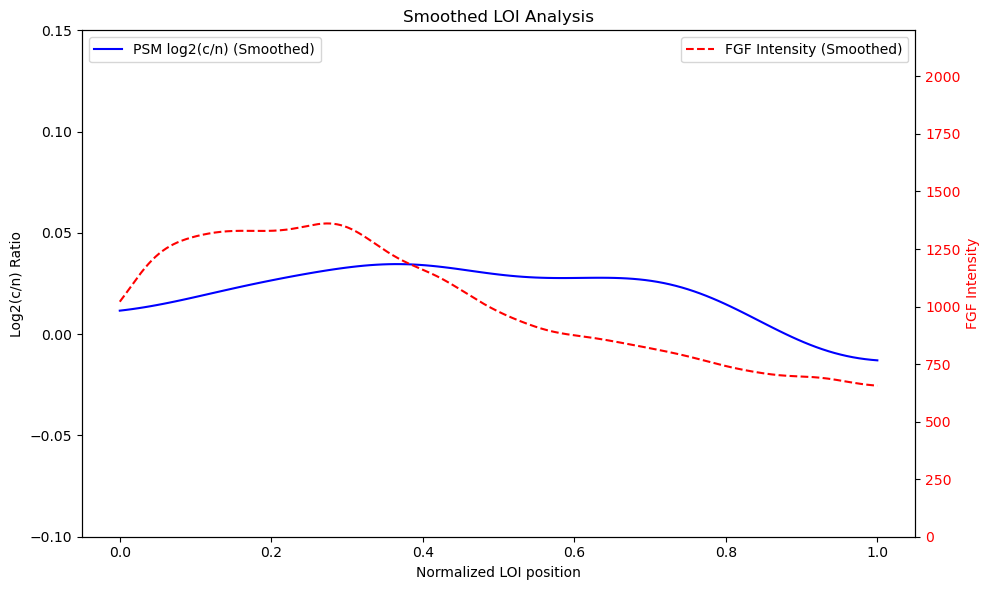

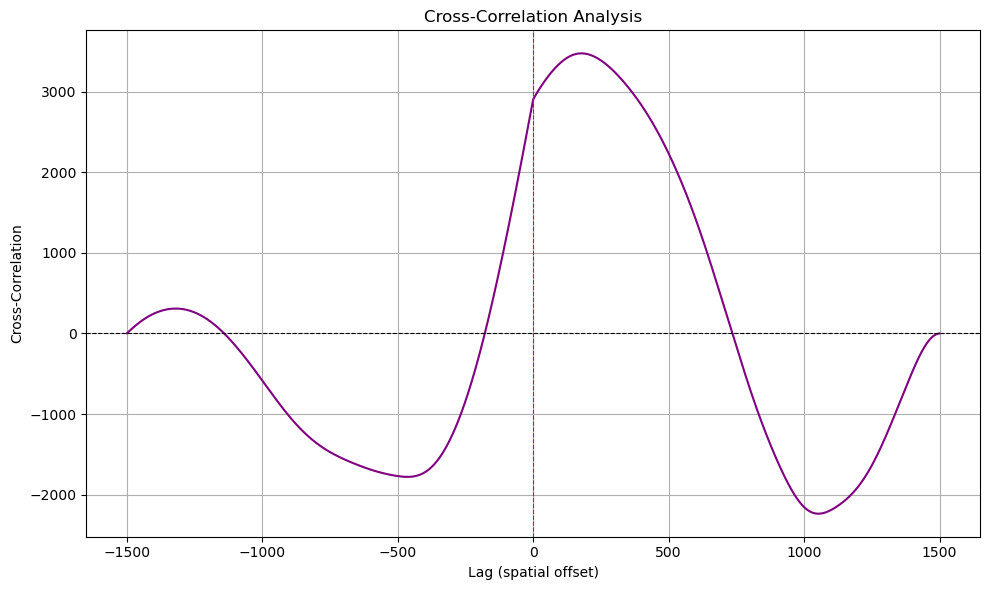

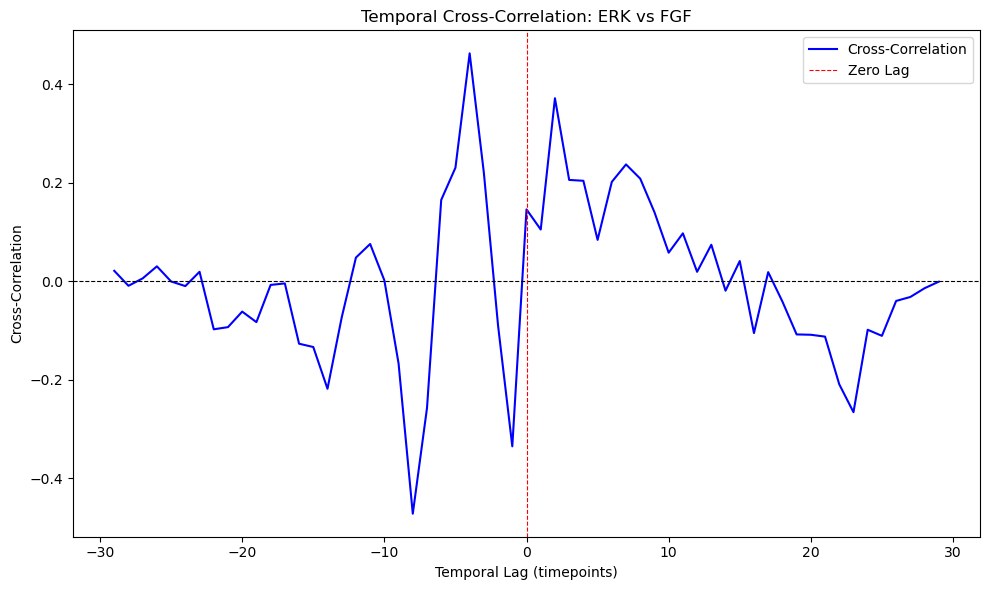

([array([-4.17795270e-02, -3.81292546e-02, -3.44740446e-02, -3.08283849e-02,
         -2.72053703e-02, -2.36177874e-02, -2.00780533e-02, -1.65971593e-02,
         -1.31841531e-02, -9.84781292e-03, -6.59552988e-03, -3.43234663e-03,
         -3.64149686e-04,  2.60632221e-03,  5.48038907e-03,  8.25584450e-03,
          1.09344497e-02,  1.35154080e-02,  1.60000226e-02,  1.83944174e-02,
          2.07007114e-02,  2.29224331e-02,  2.50626537e-02,  2.71249360e-02,
          2.91134416e-02,  3.10303368e-02,  3.28795789e-02,  3.46633243e-02,
          3.63831610e-02,  3.80388136e-02,  3.96317975e-02,  4.11625294e-02,
          4.26300964e-02,  4.40344893e-02,  4.53737641e-02,  4.66473263e-02,
          4.78532297e-02,  4.89908476e-02,  5.00579302e-02,  5.10525152e-02,
          5.19752219e-02,  5.28246533e-02,  5.35997547e-02,  5.43023717e-02,
          5.49321962e-02,  5.54901765e-02,  5.59782747e-02,  5.63996959e-02,
          5.67550031e-02,  5.70499007e-02,  5.72868631e-02,  5.74689966e-02,

In [20]:
fgf_dir = 'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/fgf/'
fgf_mask_dir = 'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/fgf_mask/'
loi_dir = 'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/loi/'
mod_erk_dir = 'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/erk/'
masks_dir = 'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/nuclear_mask/'
tissue_mask_dir = 'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/tissue/'

complete_function_erk_fgf(mod_erk_dir, masks_dir, tissue_mask_dir, loi_dir, fgf_mask_dir, fgf_dir)

In [13]:
def plot_loi_smoothe(ratios_psm, binned_fgf, 
                      smoothing_window_psm_somites=30, smoothing_window_fgf=60, 
                      y_min=-0.20, y_max=0.20, fgf_max=1500, save_path=None):

    def smooth_data(data, window):
        return gaussian_filter1d(data, sigma=window, mode='nearest')

    all_x_coords = sorted(set(list(ratios_psm.keys())))
    normalized_positions = np.linspace(0, 1, len(all_x_coords))  # Normalizzazione delle posizioni x

    psm_values = [ratios_psm.get(x, np.nan) for x in all_x_coords]
    psm_smoothed = smooth_data(np.nan_to_num(psm_values), smoothing_window_psm_somites)

    fgf_smoothed = smooth_data(binned_fgf, smoothing_window_fgf)

    # Creazione del grafico
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    ax1.plot(normalized_positions, psm_smoothed, label="PSM log2(c/n) (Smoothed)", color="blue")
    ax1.set_ylim(y_min, y_max)
    ax1.set_xlabel("Normalized LOI position")
    ax1.set_ylabel("Log2(c/n) Ratio", color="black")
    ax1.tick_params(axis='y', labelcolor="black")
    ax1.legend(loc="upper left")

    # Creazione di un asse secondario per l'intensità di FGF
    ax2 = ax1.twinx()
    ax2.plot(np.linspace(0, 1, len(fgf_smoothed)), fgf_smoothed, label="FGF Intensity (Smoothed)", color="red", linestyle="--")
    ax2.set_ylim(0, fgf_max)
    ax2.set_ylabel("FGF Intensity", color="red")
    ax2.tick_params(axis='y', labelcolor="red")
    ax2.legend(loc="upper right")

    # Impostazioni finali del grafico
    plt.title("Smoothed LOI Analysis")
    fig.tight_layout()

    # Salvataggio o visualizzazione del grafico
    if save_path:
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    plt.show()

    return psm_smoothed, fgf_smoothed, fig

In [14]:
def complete_function_erk_fgfs(mod_erk_dir, masks_dir, tissue_mask_dir, loi_dir, fgf_mask_dir, fgf_dir, pickle_dir):
    all_ratios_psm = []
    all_ratios_somites = []
    all_fgf_positions = []
    all_fgf_values = []
    
    mod_erk_files = [os.path.join(mod_erk_dir, f) for f in sorted(os.listdir(mod_erk_dir)) if f.endswith('.tif')]
    masks_files = [os.path.join(masks_dir, f) for f in sorted(os.listdir(masks_dir)) if f.endswith('.npy')]
    tissue_mask_files = [os.path.join(tissue_mask_dir, f) for f in sorted(os.listdir(tissue_mask_dir)) if f.endswith('.tif')]
    loi_files = [os.path.join(loi_dir, f) for f in sorted(os.listdir(loi_dir)) if f.endswith('.tif')]
    fgf_mask_files = [os.path.join(fgf_mask_dir, f) for f in sorted(os.listdir(fgf_mask_dir)) if f.endswith('.tif')]
    fgf_files = [os.path.join(fgf_dir, f) for f in sorted(os.listdir(fgf_dir)) if f.endswith('.tif')]

    if len(mod_erk_files) != len(masks_files) or len(mod_erk_files) != len(tissue_mask_files) or len(mod_erk_files) != len(fgf_files):
        raise ValueError("Error: the folders don't have the same length.")
    
    max_x_width = 0
    for tissue_mask_file in tissue_mask_files:
        tissue_mask = io.imread(tissue_mask_file)
        non_zero_x = np.where(np.any(tissue_mask > 0, axis=0))[0]
        min_x, max_x = non_zero_x[0], non_zero_x[-1]
        width = max_x - min_x
        if width > max_x_width:
            max_x_width = width
        
    for i, (mod_erk_file, masks_file, tissue_mask_file, loi_file, fgf_mask_file, fgf_file) in enumerate(
            zip(mod_erk_files, masks_files, tissue_mask_files, loi_files, fgf_mask_files, fgf_files)):

        mod_erk = io.imread(mod_erk_file)
        fgf = io.imread(fgf_file)
        fgf_mask = io.imread(fgf_mask_file)
        masks = load_mask_data(masks_file)
        tissue_mask = io.imread(tissue_mask_file)
        loi = io.imread(loi_file)

        pickle_file_psm = os.path.join(pickle_dir, f'ratios_psm_timepoint_{i}.pkl')
        if os.path.exists(pickle_file_psm):
            with open(pickle_file_psm, 'rb') as f:
                ratios_psm = pickle.load(f)
        all_ratios_psm.append(ratios_psm)

        pickle_file_fgf_pos = os.path.join(pickle_dir, f'fgf_position_{i}.pkl')
        if os.path.exists(pickle_file_fgf_pos):
            with open(pickle_file_fgf_pos, 'rb') as f:
                fgf_positions = pickle.load(f)
        all_fgf_positions.append(fgf_positions)

        pickle_file_fgf_val = os.path.join(pickle_dir, f'fgf_value_{i}.pkl')
        if os.path.exists(pickle_file_fgf_val):
            with open(pickle_file_fgf_val, 'rb') as f:
                fgf_values = pickle.load(f)
        all_fgf_values.append(fgf_values)

        binned_fgf = fgf_values
        
        sorted_indices = sorted(ratios_psm.keys()) 
        ratios_psm_values = np.array([ratios_psm[i] for i in sorted_indices])
        
        plot_smooth_path = f'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/results_comb/plots_smooth_new_{i}.tif'
        psm_smoothed, fgf_smoothed, plot_smooth = plot_loi_smoothe(ratios_psm, binned_fgf, smoothing_window_psm_somites=30, smoothing_window_fgf=100, y_min=-0.20, y_max=0.20, fgf_max=2500, save_path=plot_smooth_path)
        plots_smooth.append(plot_smooth)

        all_psm_curves.append(psm_smoothed)
        all_fgf_curves.append(fgf_smoothed)

        all_x_coords = sorted(set(list(ratios_psm.keys())))
        normalized_positions = np.linspace(0, 1, len(all_x_coords))
        common_grid = np.linspace(0, 1, max(len(psm_smoothed), len(fgf_smoothed)))

        interp_psm = interp1d(np.linspace(0, 1, len(psm_smoothed)), psm_smoothed, kind='linear', fill_value="extrapolate")
        interp_fgf = interp1d(np.linspace(0, 1, len(fgf_smoothed)), fgf_smoothed, kind='linear', fill_value="extrapolate")

        psm_smoothed = interp_psm(common_grid)
        fgf_smoothed = interp_fgf(common_grid)

        lag_positions, cross_corr = calculate_cross_correlation(psm_smoothed, fgf_smoothed, common_grid)

        corr_path= f'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/correlation/corr_{i}.tif'
        correlation=plot_cross_correlation(lag_positions, cross_corr, title="Cross-Correlation Analysis", save_path=corr_path)
        #correlations.append(correlation)

    lags, cross_corr = calculate_temporal_cross_correlation(all_psm_curves, all_fgf_curves)
    corr_t_path= f'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/correlation/corr_t_{i}.tif'
    plot_temporal_cross_correlation(lags, cross_corr, save_path=corr_t_path)
        
    return all_psm_curves, all_fgf_curves, plots_smooth

In [15]:
fgf_dir = 'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/fgf/'
fgf_mask_dir = 'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/fgf_mask/'
loi_dir = 'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/loi/'
mod_erk_dir = 'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/erk/'
masks_dir = 'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/nuclear_mask/'
tissue_mask_dir = 'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/tissue/'
pickle_dir = 'E:/Agnese/20241212_fgfeGFP_h2a_modERK-rnanuclow/20241212_124318_Experiment/pos1/every_10_min/saved_ratios/'

complete_function_erk_fgfs(mod_erk_dir, masks_dir, tissue_mask_dir, loi_dir, fgf_mask_dir, fgf_dir, pickle_dir)

UnboundLocalError: local variable 'ratios_psm' referenced before assignment